# Sentiment Analysis for IMBD Movie Reviews

# Content

* [Introduction](#introduction)
* [Initialization](#initialization)
* [Data Exploration](#data_exploration)
	* [Conclusion](#conclusion)
* [Exploratory Data Analysis (EDA)](#eda)
	* [Conclusion](#conclusion)
* [Evaluation Procedure](#evaluation)
* [Normalization](#normalization)
* [Train/Test Split](#train_test_split)
* [Working with Models](#models)
	* [Model 0 – constant](#model_0)
	* [Model 1 – NLTK, TF-IDF](#nltk)
		* [TF-IDF](#tf_idf)
		* [Logistic Regression Model](#lr)
		* [Naïve Bayes Classifier Model](#nb)
		* [LightGBM Classifier Model](#lgbm)
	* [Model 2 – spaCy, TF-IDF](#spacy)
		* [Logistic Regression Model](#lr)
		* [Naïve Bayes Classifier Model](#nb)
		* [LightGBM Classifier Model](#lgbm)
	* [Model 3 – BERT](#bert)
		* [Logistic Regression Model](#lr)
		* [Naïve Bayes Classifier Model](#nb)
		* [LightGBM Classifier Model](#lgbm)
* [My Reviews](#my_reviews)
	* [Logistic Regression Model](#lr)
	* [Naïve Bayes Classifier Model](#nb)
	* [LightGBM Classifier Model](#lgbm)
	* [Conclusion](#conclusion)
* [Findings](#findings)


## Introduction 

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. They want to develop a model that automatically detects negative reviews. We will be using the dataset of IMBD movie reviews with polarity labeling to build a model for classifying positive and negative reviews. 

**Data Description:**

* `review` - the review text
* `pos` - the target
  * '0' for negative
  * '1' for positive
* `ds_part` - 'train'/'test' for the train/test part of dataset, correspondingly 

**Objectives:**
* Train and test different models for the given training dataset
* Compose reviews and classify them with all the models 
* Check for differences between the testing results of models 
* Obtain an F1 score of at least 0.85

## Initialization

In [3]:
# Loading all libraries 
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import torch

!pip install transformers
import transformers

import re
import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from functools import reduce

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     |████████████████████████████████| 363 kB 1.4 MB/s eta 0:00:01


In [4]:
# Configuration for graphs
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Configuration to create graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# Enabling progress_apply to create a progress meter and estimate
tqdm.pandas()

In [6]:
# Loading the data
try:
  df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes':'Int64'})
except:
  df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Data Exploration 

Description of the data:

* `review` - the review text
* `pos` - the target
  * '0' for negative
  * '1' for positive
* `ds_part` - 'train'/'test' for the train/test part of dataset, correspondingly

In [7]:
# Obtaining the first five rows of the table
df_reviews.head()

tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage implies that Warren Beatty and Gold...       1  neg    0   
1  How the hell did they get this made?! Presenti...       1  neg    0   
2  There is no real story the film seems more lik...       3  neg    0   
3  Um .... a serious film about troubled teens in...       7  pos    1   
4  I'm totally agree with GarryJohal from Singapo...       9  pos    1   

  ds_part   idx  
0   train  8335  
1   train  8336  
2    test  2489  
3    test  9280  
4    test  9281

In [8]:
# Obtaining number of rows and columns
shape = df_reviews.shape
print('The table has {} rows and {} columns'.format(shape[0], shape[1]))

The table has 47331 rows and 17 columns


In [9]:
# Obtaining statistical summary of the table
df_reviews.describe()

start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000  4.732900e+04  47331.000000   
mean    1989.631235      0.001732        5.998278  2.556292e+04      5.484608   
std       19.600364      0.041587        1.494289  8.367004e+04      3.473109   
min     1894.000000      0.000000        1.400000  9.000000e+00      1.000000   
25%     1982.000000      0.000000        5.100000  8.270000e+02      2.000000   
50%     1998.000000      0.000000        6.300000  3.197000e+03      4.000000   
75%     2004.000000      0.000000        7.100000  1.397400e+04      9.000000   
max     2010.000000      1.000000        9.700000  1.739448e+06     10.000000   

                pos           idx  
count  47331.000000  47331.000000  
mean       0.498954   6279.697999  
std        0.500004   3605.702545  
min        0.000000      0.000000  
25%        0.000000   3162.000000  
50%        0.000000   6299.000000  
75%        1.000000   9412.000000  
max        1.000000  12499.000000

In [10]:
# Obtaining general info 
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Since there are 47,331 rows per column, we observe missing values in the `average_rating` and `votes` column. Since each of these columns are only missing 2 values, we can drop these rows without it affecting the data. 

In [11]:
# Dropping missing values
df_reviews = df_reviews.dropna()

# Checking to see if missing values have been dropped
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [12]:
# Checking for duplicates
df_reviews.duplicated().sum()

0

In [13]:
# Checking info after manipulations
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

### Conclusion 

Our dataset contains 47,331 rows and 17 columns. The columns, `average_rating` and `votes` contained missing values. Since the missing data for each column was less than 5% of our data, we were able to drop these values. After manipulations, our table now contains 47,329 rows and 17 columns. Our dataframe contained no duplicates. All column names follow good rules of style. 

Now we will carry out exploratory data analysis to perform initial investigations on the data so as to discover patterns and spot anomalies.

## Exploratory Data Analysis (EDA)

We will begin by checking the number of movies and reviews over years.

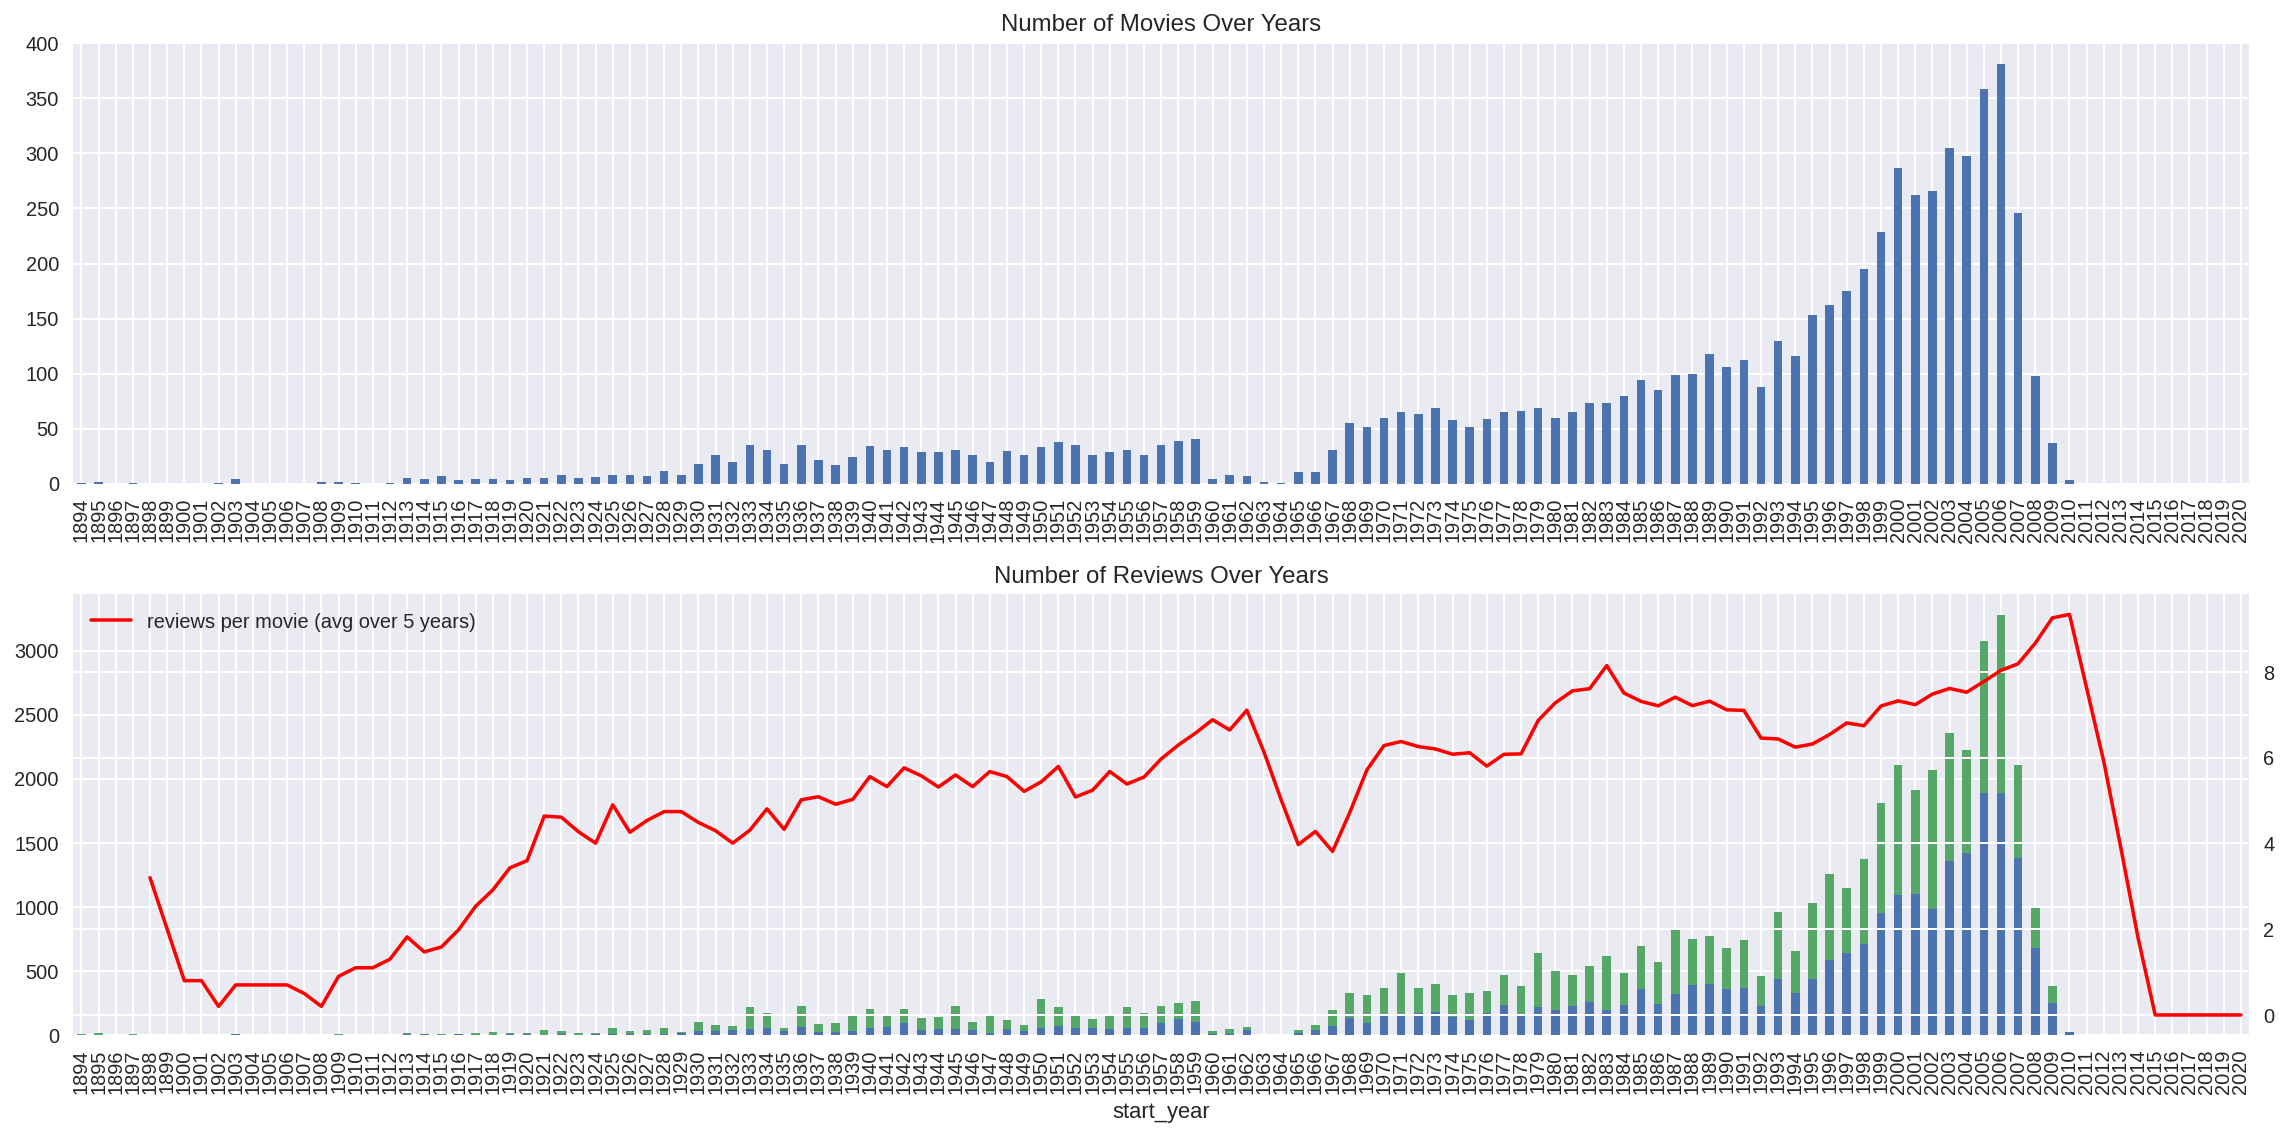

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='red', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see that the number of movies and reviews per movie increase over the years until 2007, then we see a sharp decline in both movies released and subsequently movie reviews.

Now we will check the distribution of number of reviews per movie with the exact counting and KDE.

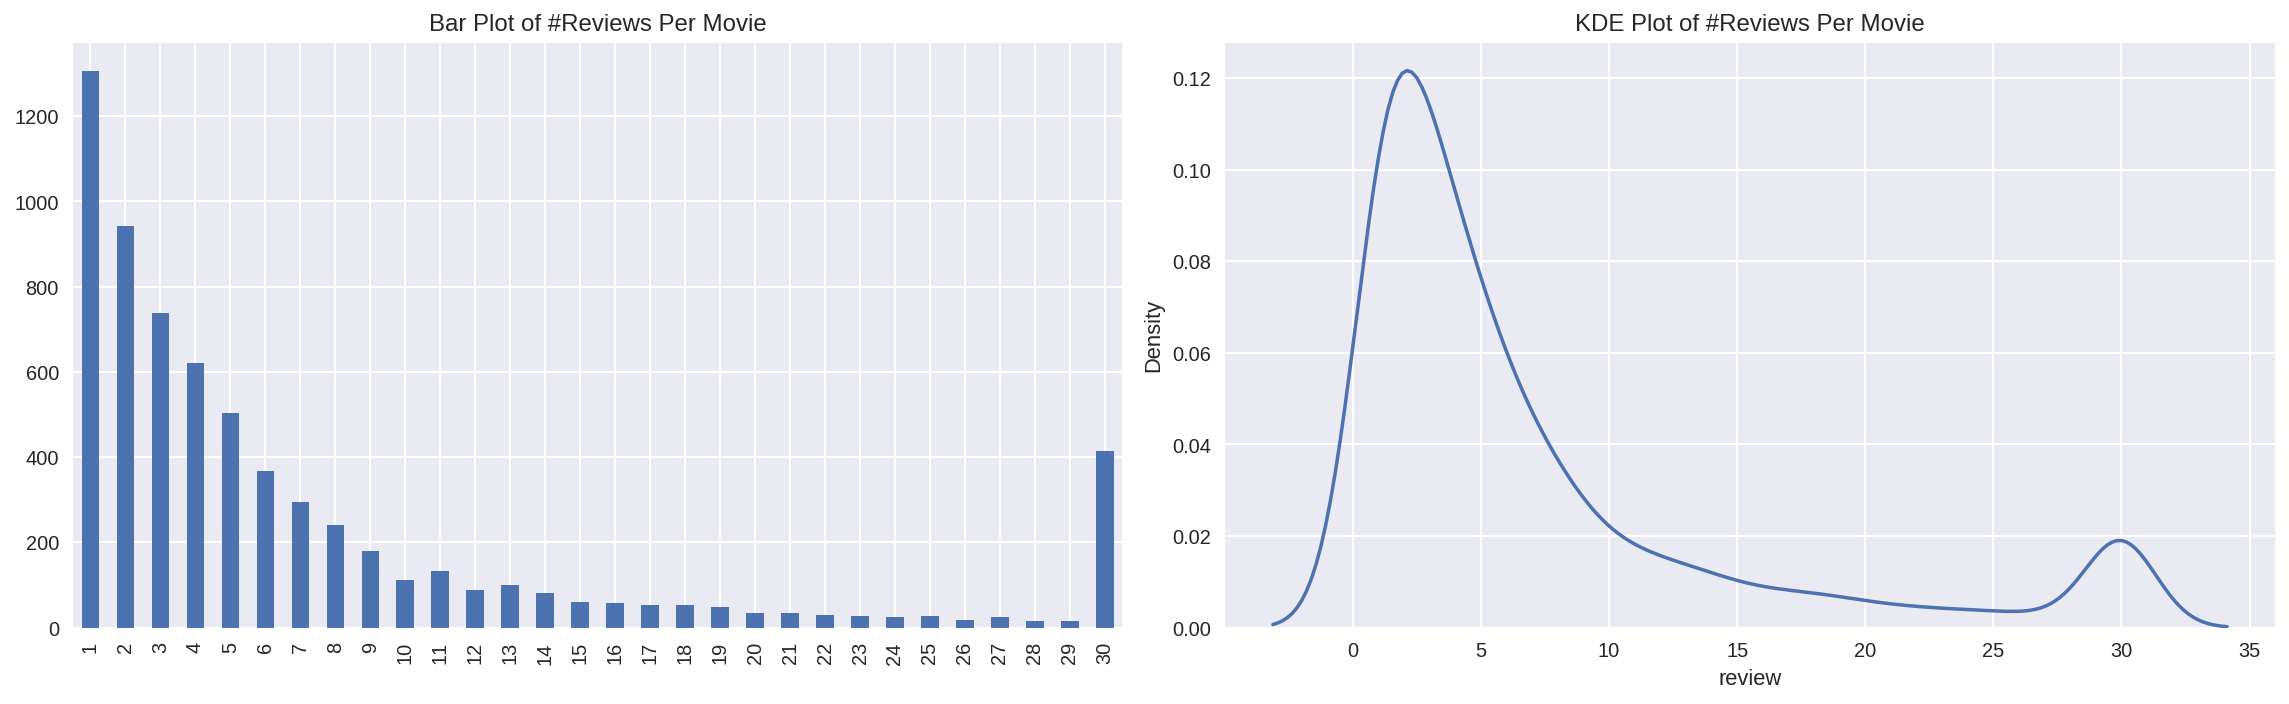

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

From our plot, we see that movie 1 contains the most reviews and then it gradually declines and sees an uptick in reviews for movie 30.

In [16]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

The column `pos` represents the target. It describes the tonality of the text where '0' is negative and '1' is positive. From our value counts, we see that there are 23,715 negative reviews and 23,614 positive reviews. 

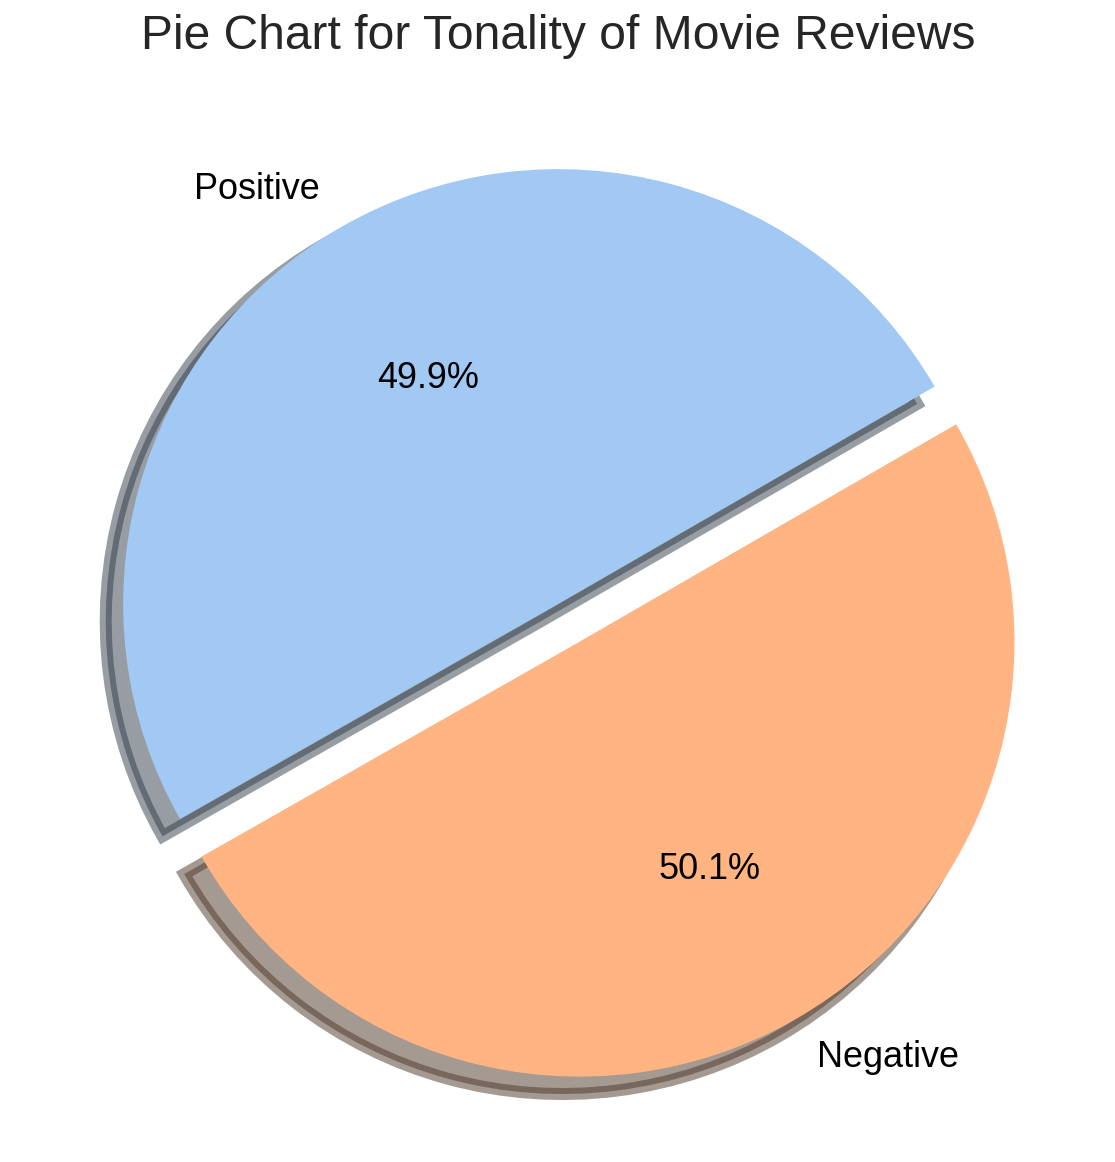

In [17]:
# Plotting pie chart for pos
fig = plt.figure(figsize=(10,10))

pos = df_reviews[df_reviews['pos'] == 1]
neg = df_reviews[df_reviews['pos'] == 0]
count = [pos['pos'].count(), neg['pos'].count()]

label = ['Positive', 'Negative']

colors = sns.color_palette('pastel')

plt.pie(count, labels=label,
        autopct ='%.1f%%',
        shadow = True,
        colors = colors,
        explode = (0, 0.1), 
        startangle = 30, 
        textprops = {'color': 'Black','fontsize':18}, 
        wedgeprops = {'linewidth': 6} )

plt.title('Pie Chart for Tonality of Movie Reviews', fontsize=24)
plt.show()

From our pie chart, we can see that there is almost an even distribution of positive and negative ratings. Roughly 49.9% of the ratings are positive and the other 50.1% are negative. 

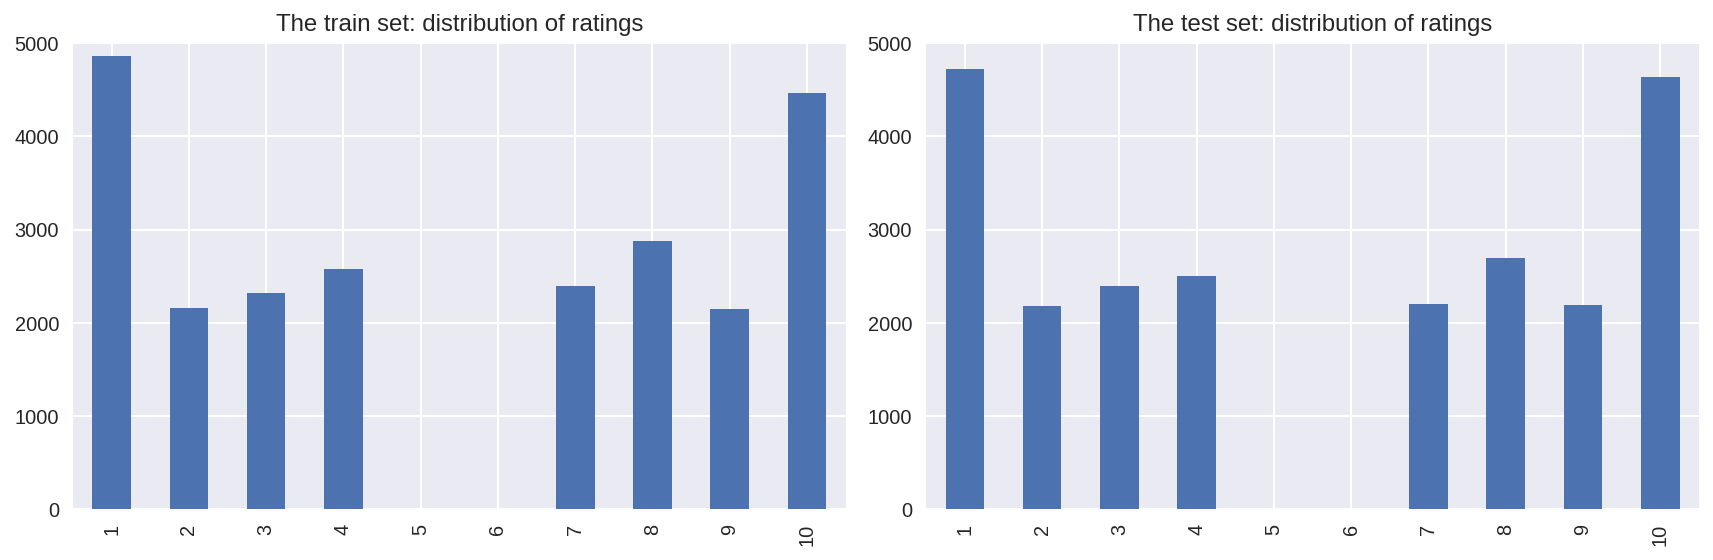

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The training set and test set have very similar distribution of ratings. We can also plot the distribution of negative and positive reviews over the years for two parts of the dataset.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


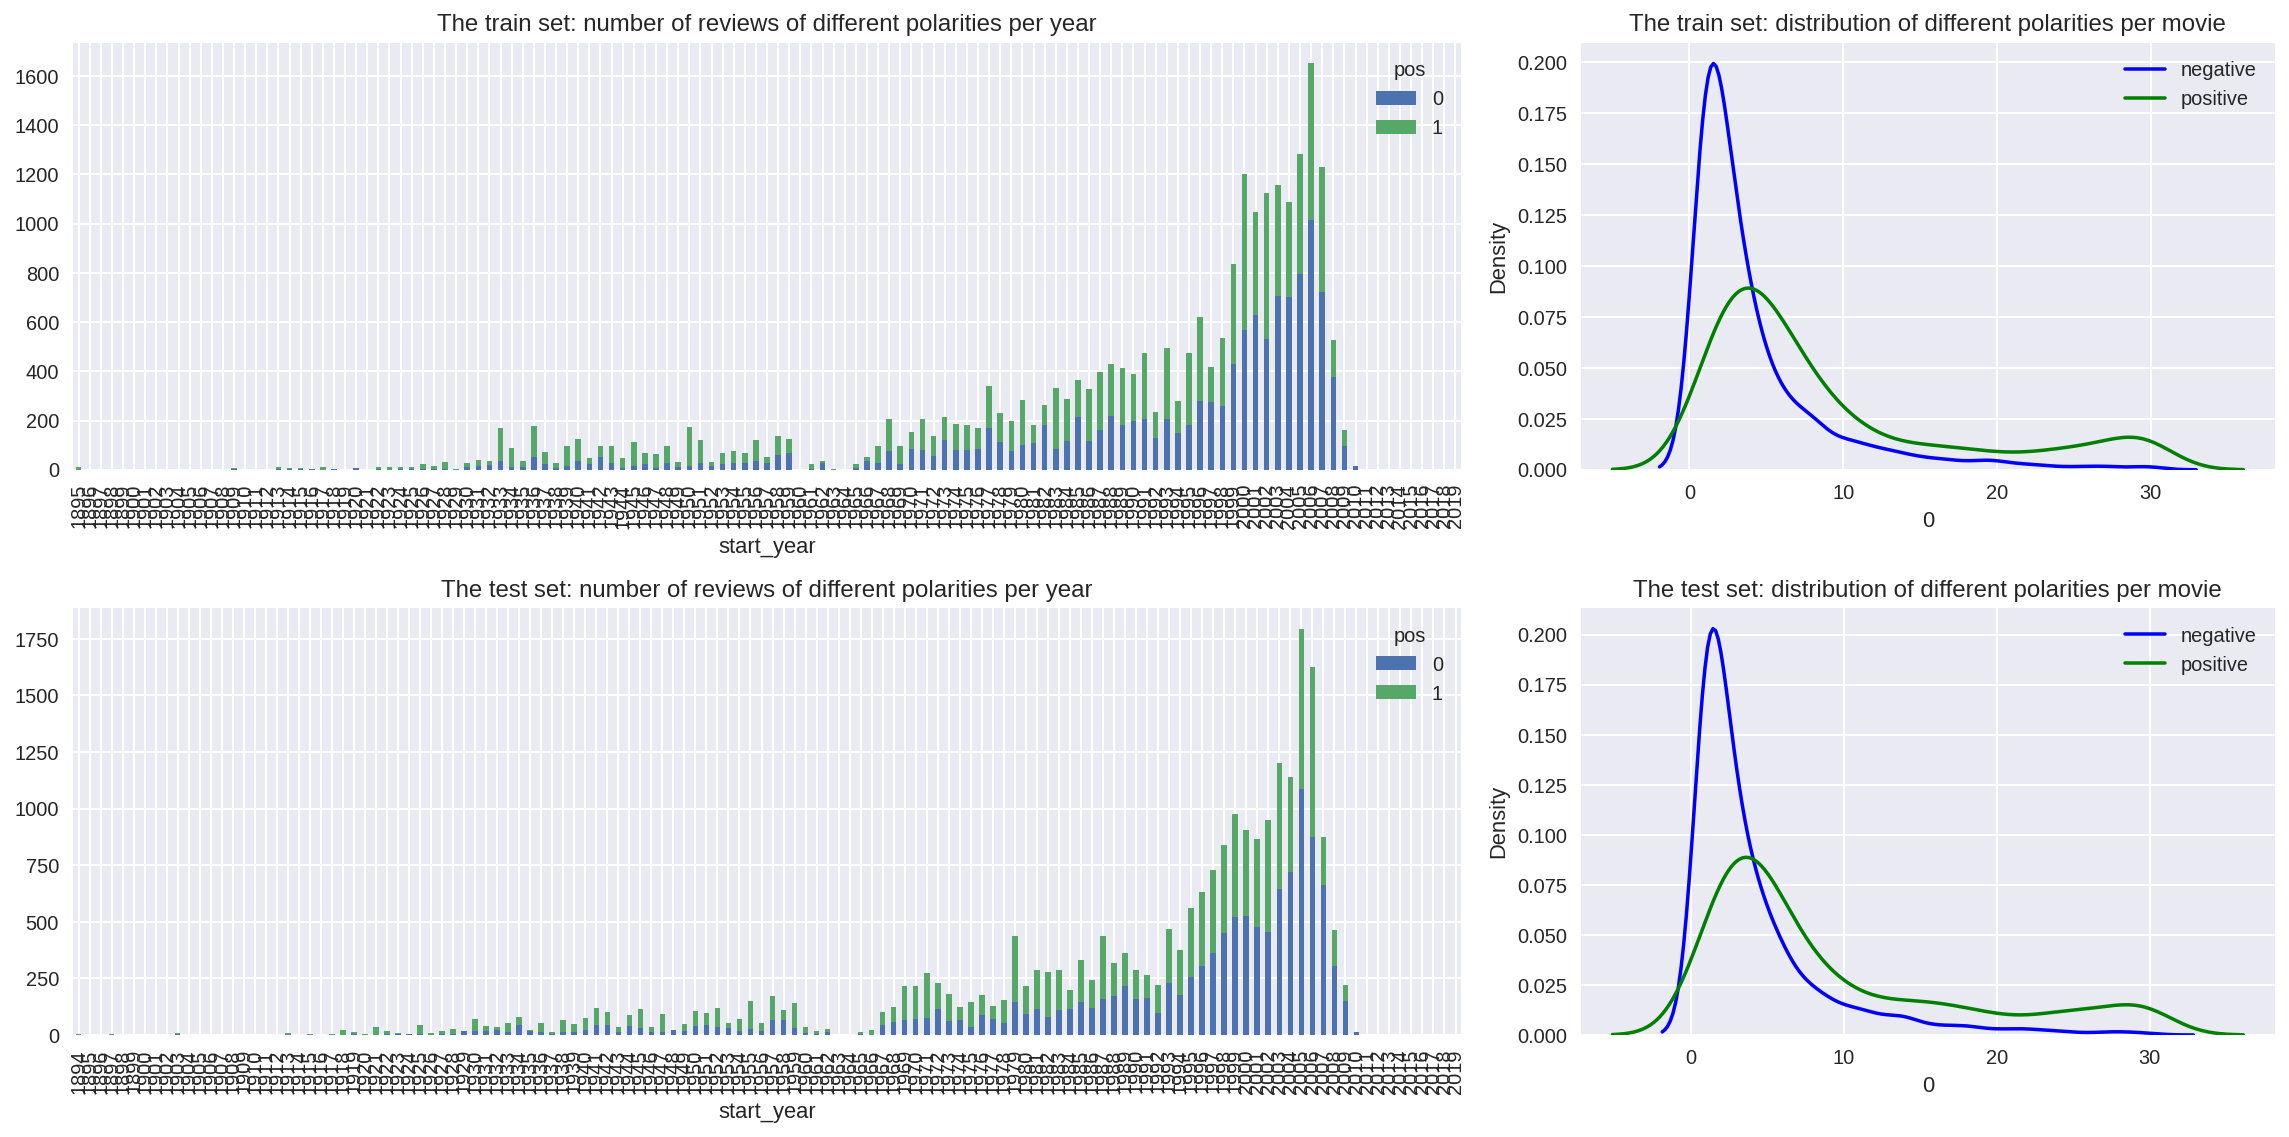

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

We can see that the distribution of different polarities per movie and year are roughly the same for the training set and test set. We will now visualize words that carry meaning with a word cloud.

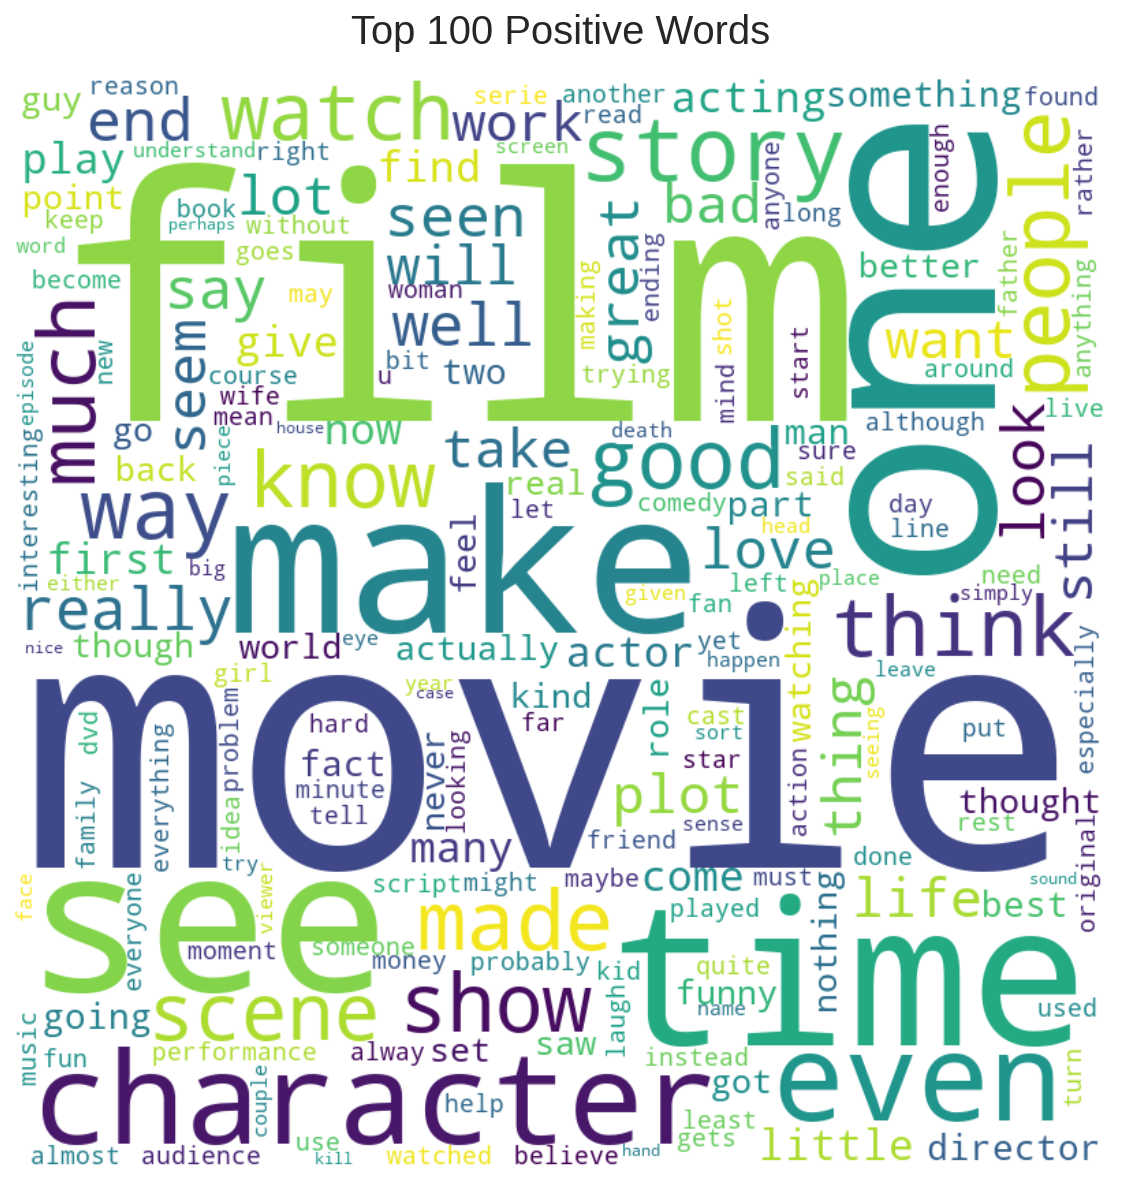

In [20]:
# Top 100 positive words
comment_words = ''
stopwords = set(STOPWORDS)
positive_df = df_reviews[df_reviews['pos'] == 1]['review'][:100]          # 1 = positive, 0 = negative
positive_df = reduce(lambda a, b: a+b, positive_df)
 
# iterate through the csv file
for val in df_reviews.review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
cloud_positives = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud_positives, interpolation='bilinear') 
plt.title('Top 100 Positive Words', y = 1.02, size = 20) 
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

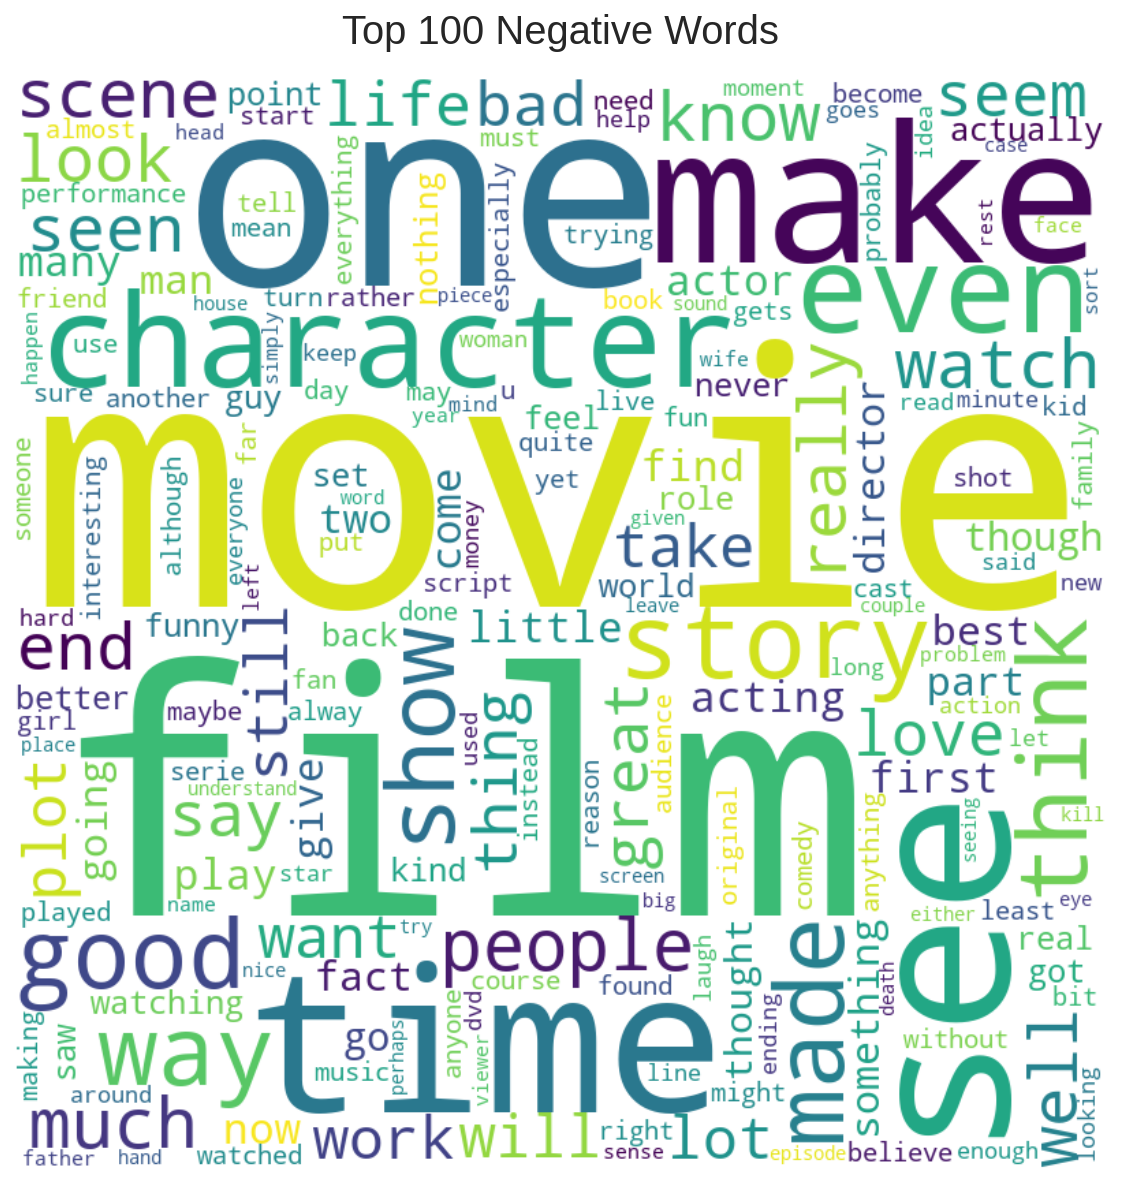

In [21]:
# Top 100 negative words
comment_words = ''
stopwords = set(STOPWORDS)
negative_df = df_reviews[df_reviews['pos'] == 0]['review'][:100]          # 1 = positive, 0 = negative
negative_df = reduce(lambda a, b: a+b, negative_df)
 
# iterate through the file
for val in df_reviews.review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "


cloud_negatives = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud_negatives, interpolation='bilinear') 
plt.title('Top 100 Negative Words', y = 1.02, size = 20) 
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Conclusion

From our exploratory data analysis, we saw that the number of movies and reviews per movie increased over the years until 2007. Then there was a sharp decline in both movies released and movie reviews. We checked the distribution of the number of reviews per movie with the exact counting and KDE. We saw that movie 1 contained the most reviews and then gradually declined until movie 30. From our pie chart of the `pos` column, we saw that there was almost an even distribution of positive and negative ratings. Roughly 49.9% of the ratings are positive and the other 50.1% are negative. We plotted the distribution of ratings for the training set and test set, and saw that they both had a similar distribution. We also visualized words that carry meaning with a word cloud.

## Evaluation Procedure

In [22]:
# function to evaluate classification models
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return



## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [23]:
# Function to keep texts in lowercase and without any digits, punctuations marks etc.
def clean_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = " ".join(text.split())
    return text.lower()


In [24]:
# Creating new column for for normalized text
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

# Checking to see if all text are in lower case 
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Train / Test Split

The whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with Models

### Model 0 - Constant

In [26]:
%%time 

# Dummy classifier model
dummy = DummyClassifier(constant=None, random_state=12345, strategy='stratified')
dummy.fit(X_train, y_train)

CPU times: user 2.16 ms, sys: 215 µs, total: 2.38 ms
Wall time: 1.42 ms


DummyClassifier(random_state=12345, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


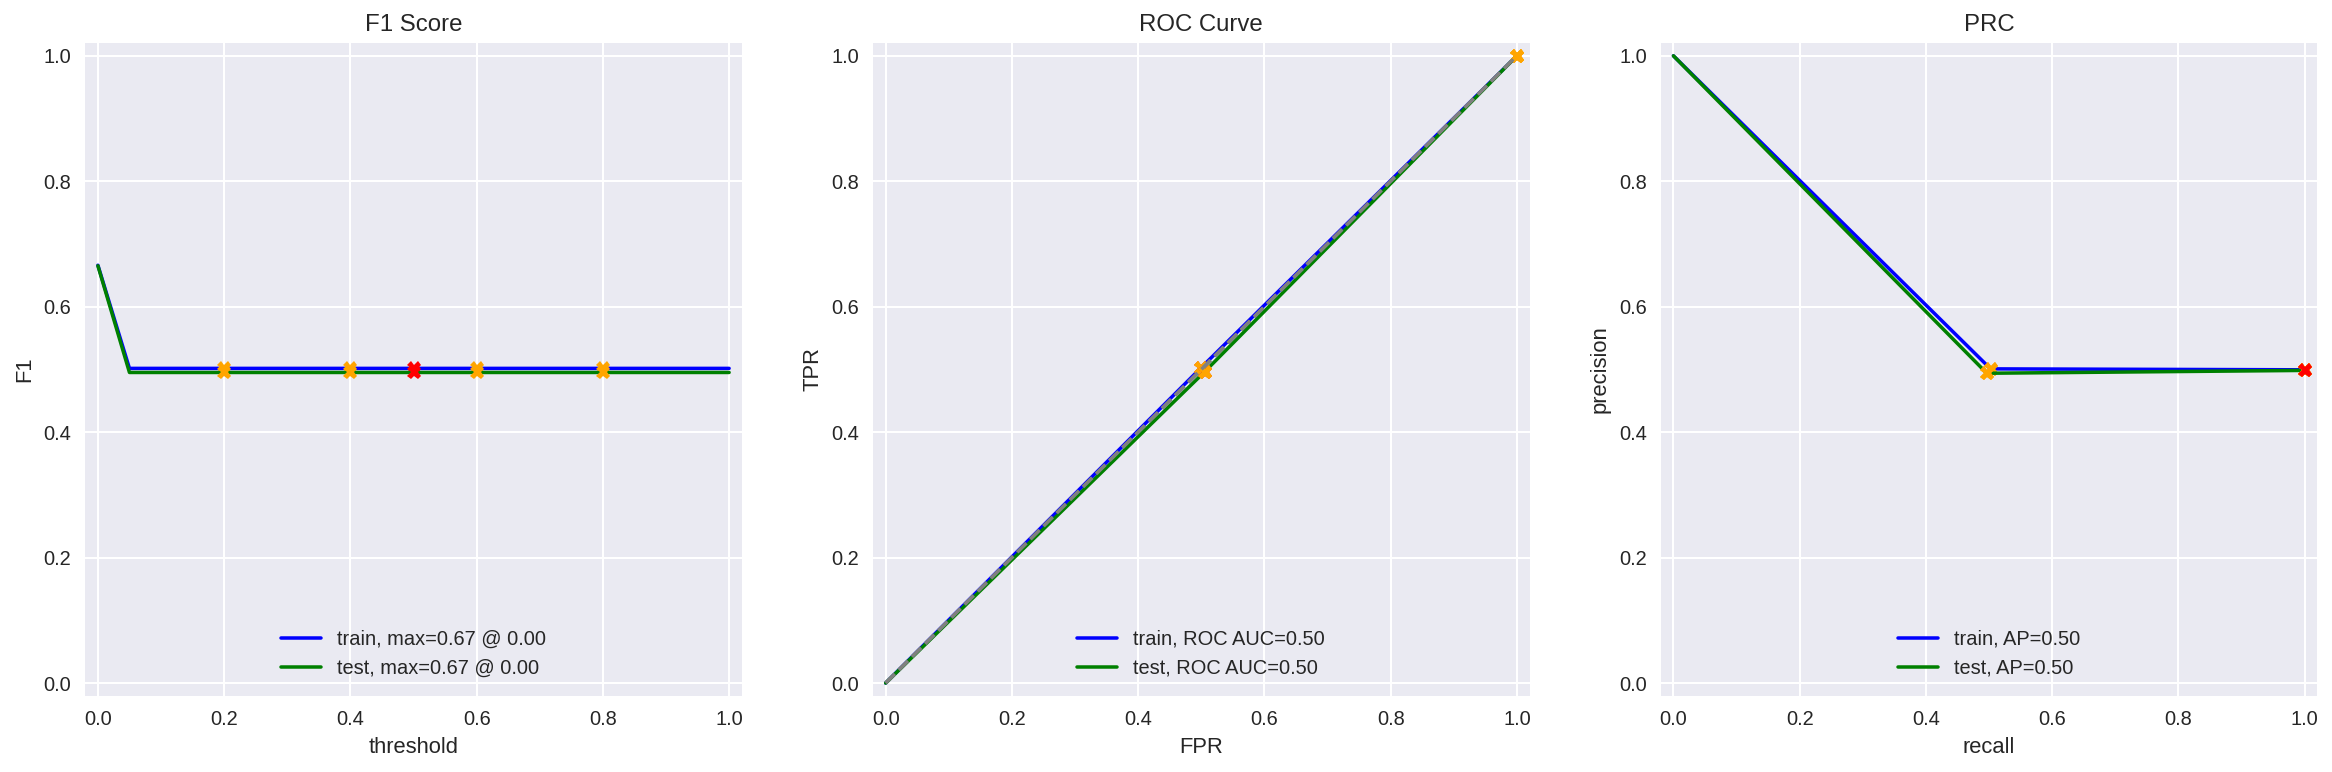

In [27]:
# Evaluating model
evaluate_model(dummy, X_train, y_train, X_test, y_test)

This dummy classifier model serves as our baseline model. We obtained an accuracy of 50% and a F1 score of 0.5. 

### Model 1 - NLTK, TF-IDF 

#### TF-IDF

In [28]:
# Text preprocessing with NLTK
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

In [29]:
# Calculating TF-IDF for train and test sets
count_tf_idf.fit(X_train) 
nltk_X_train = count_tf_idf.transform(X_train)
nltk_X_test = count_tf_idf.transform(X_test)

#### Logistic Regression Model

In [30]:
%%time

# Logisitic regression model with NLTK
lr_nltk = LogisticRegression(random_state=12345)
lr_nltk.fit(nltk_X_train, y_train)

CPU times: user 6.2 s, sys: 6.19 s, total: 12.4 s
Wall time: 12.3 s


LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


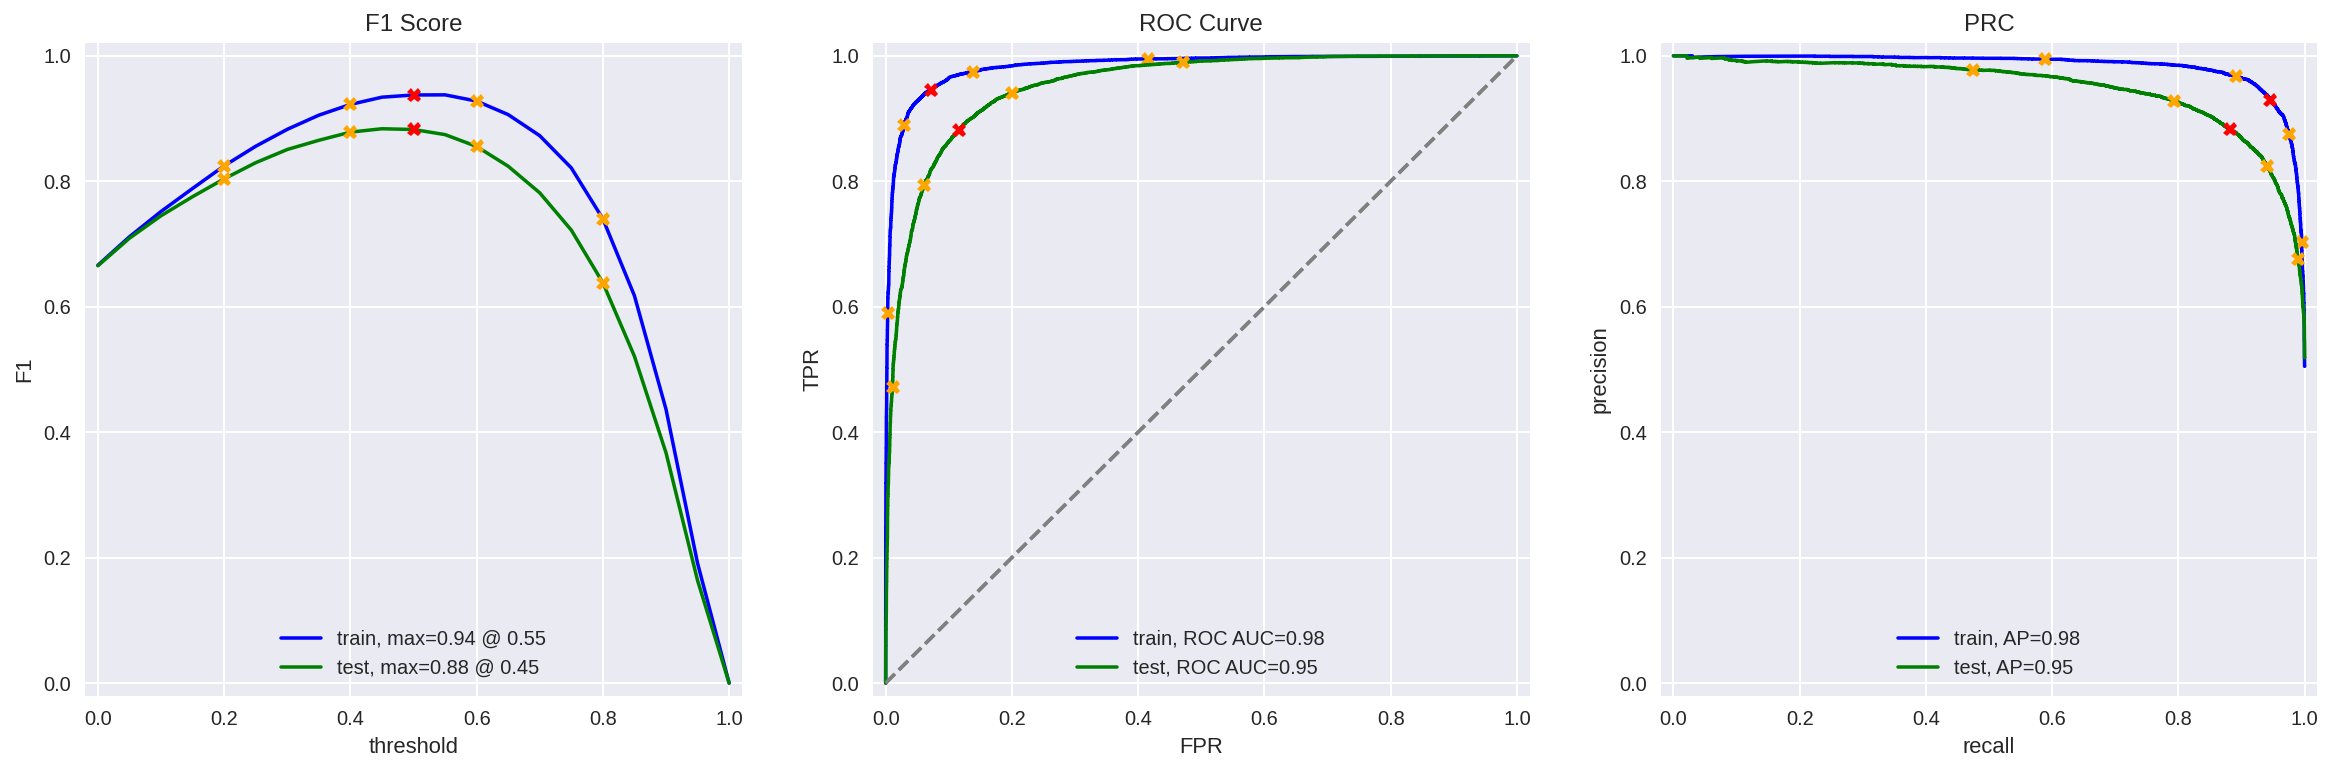

In [31]:
# Evaluating model 
evaluate_model(lr_nltk, nltk_X_train, y_train, nltk_X_test, y_test)

#### Naive Bayes Classifier Model

In [32]:
%%time

# Naive Bayes classifier model with NLTK
nb_nltk = MultinomialNB()
nb_nltk.fit(nltk_X_train, y_train)

CPU times: user 25.1 ms, sys: 98 µs, total: 25.2 ms
Wall time: 28.5 ms


MultinomialNB()

          train  test
Accuracy   0.92  0.83
F1         0.92  0.82
APS        0.97  0.91
ROC AUC    0.97  0.92


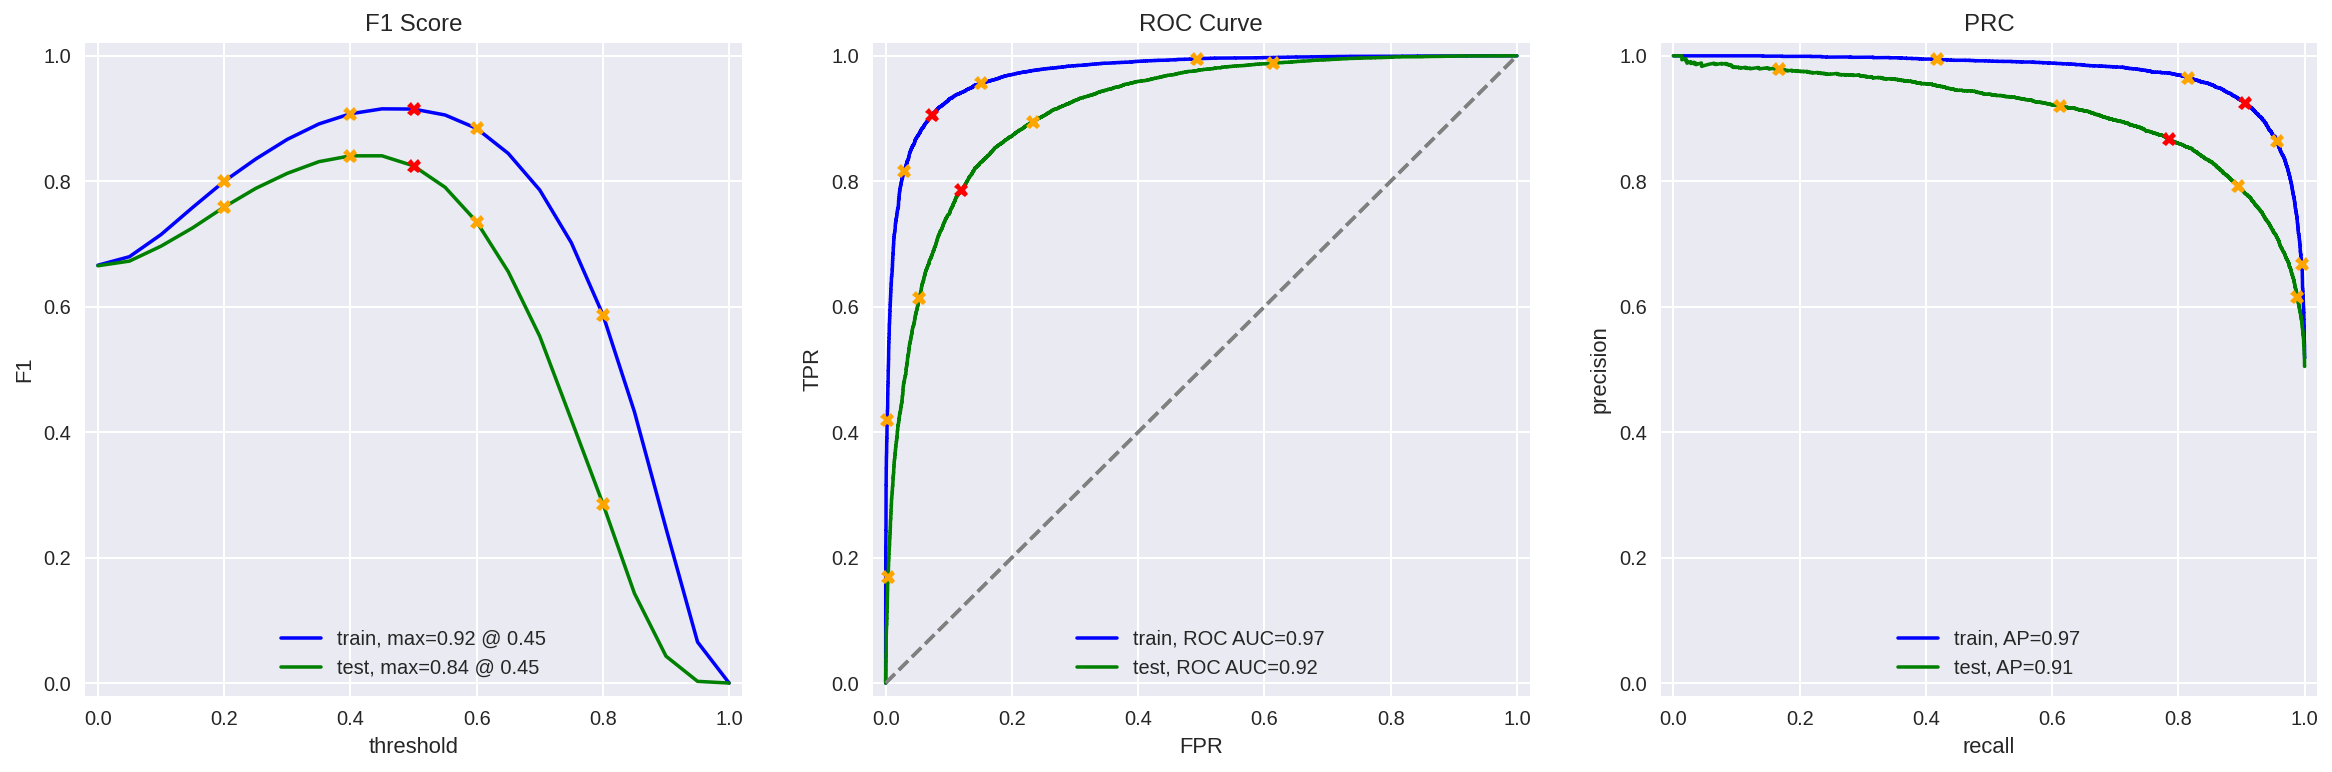

In [33]:
# Evaluating model 
evaluate_model(nb_nltk, nltk_X_train, y_train, nltk_X_test, y_test)

#### LightGBM Classifier Model

In [ ]:
%%time

# LightGBM classifier model with NLTK
lgbm_nltk = LGBMClassifier(random_state=12345)
lgbm_nltk.fit(nltk_X_train, y_train)

In [ ]:
# Evaluating model
evaluate_model(lgbm_nltk, nltk_X_train, y_train, nltk_X_test, y_test)

#### Conclusion 

Using NLTK to preprocess texts, we obtained a F1-score of 0.88 for the logistic regression model. The Naïve Bayes classification model obtained a F1-score of 0.82 which falls below the required F1 score of at least 0.85. The LightGBM classification model obtained a F1-score of 0.86. The best model to use with NLTK was the logistic regression model. It was able to train the model fast and achieve the highest F1 score.

### Model 2 - spaCy, TF-IDF

In [150]:
# List of lemmatized words
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [151]:
# Text pre-processing with spaCy
def lemmatize_spacy(text):
    doc = nlp(text.lower())
    lemmas = []
    lemmas = [token.lemma_ for token in doc]
    lemmatize_spacy = " ".join(lemmas)
    return lemmatize_spacy

In [152]:
# Applying lemmatization to features with spaCy
df_reviews_train['review_spacy'] = X_train.apply(lemmatize_spacy)
df_reviews_test['review_spacy'] = X_test.apply(lemmatize_spacy)

# Calculating TF-IDF for train and test samples
spacy_X_train = count_tf_idf.fit_transform(df_reviews_train['review_spacy'])
spacy_X_test = count_tf_idf.transform(df_reviews_test['review_spacy'])



#### Logistic Regression Model

In [153]:
%%time

# Logisitic regression model with SpaCy
lr_spacy = LogisticRegression(random_state=12345)
lr_spacy.fit(spacy_X_train , y_train)

CPU times: user 1.78 s, sys: 1.85 s, total: 3.63 s
Wall time: 1.9 s


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


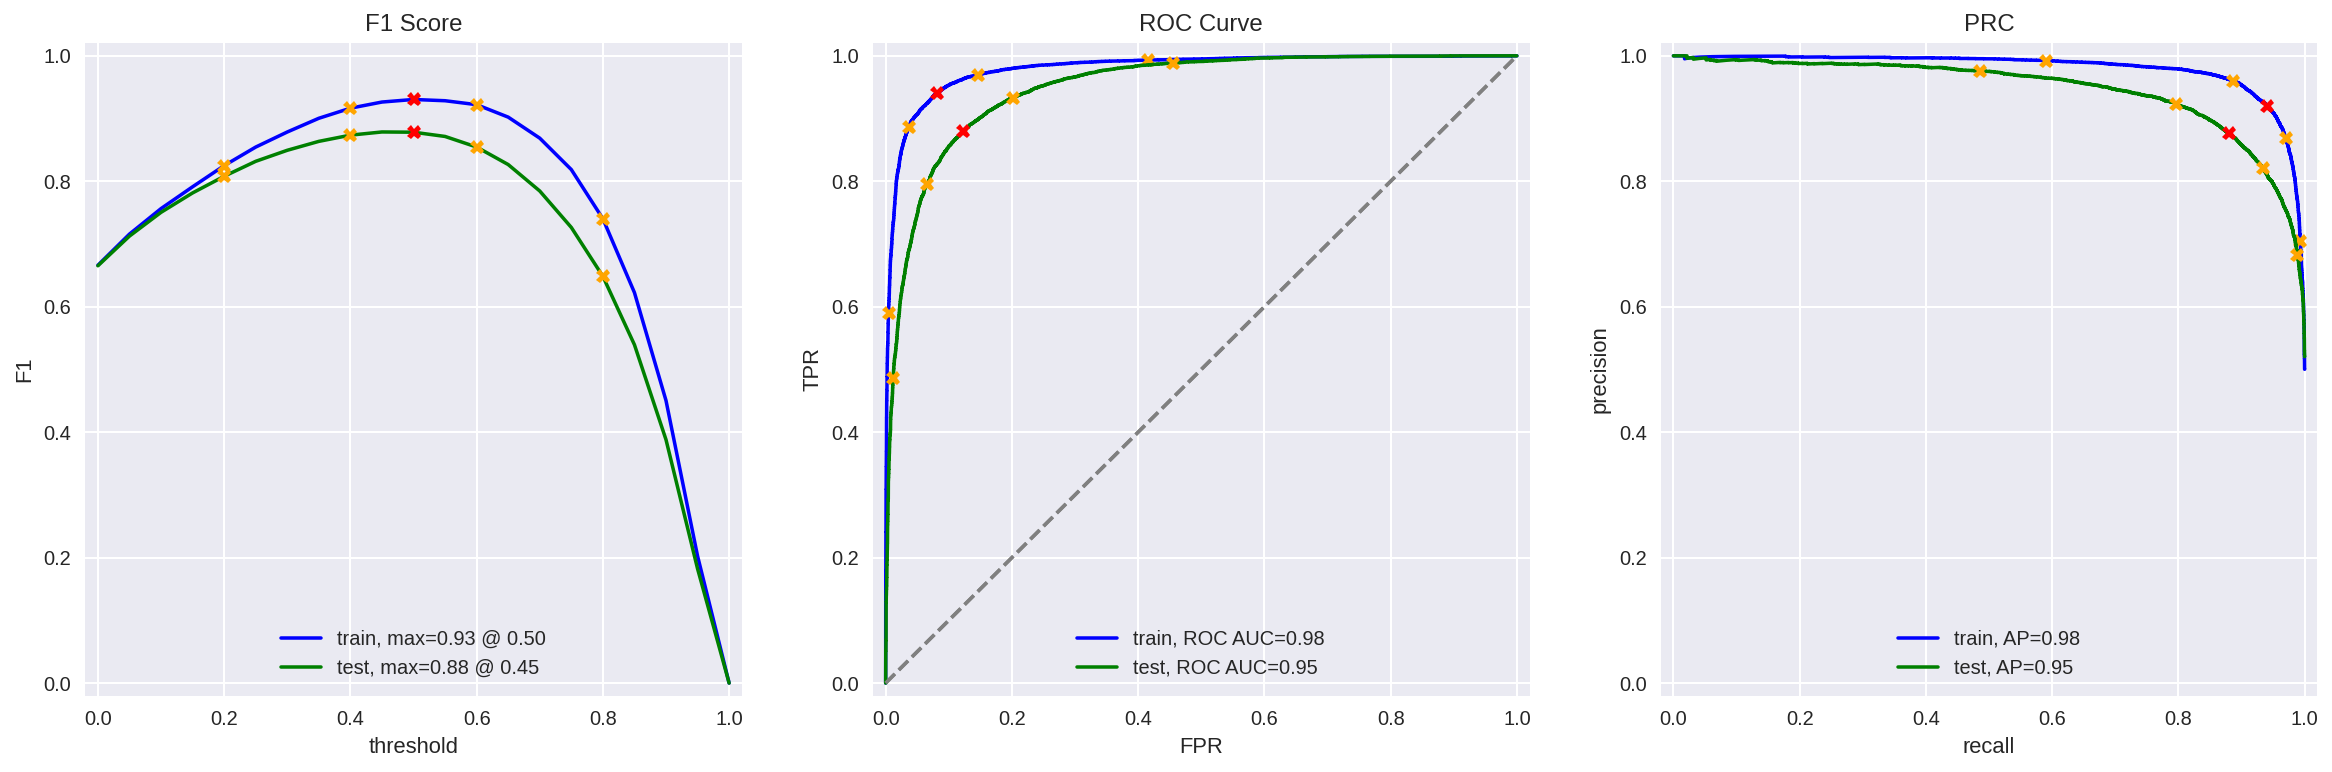

In [154]:
# Evaluating model
evaluate_model(lr_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### Naive Bayes Classifier Model

In [155]:
%%time

# Naïve Bayes classifier model with SpaCy
nb_spacy = MultinomialNB()
nb_spacy.fit(spacy_X_train, y_train)



CPU times: user 30.3 ms, sys: 0 ns, total: 30.3 ms
Wall time: 30.4 ms


          train  test
Accuracy   0.91  0.82
F1         0.91  0.81
APS        0.97  0.90
ROC AUC    0.97  0.91


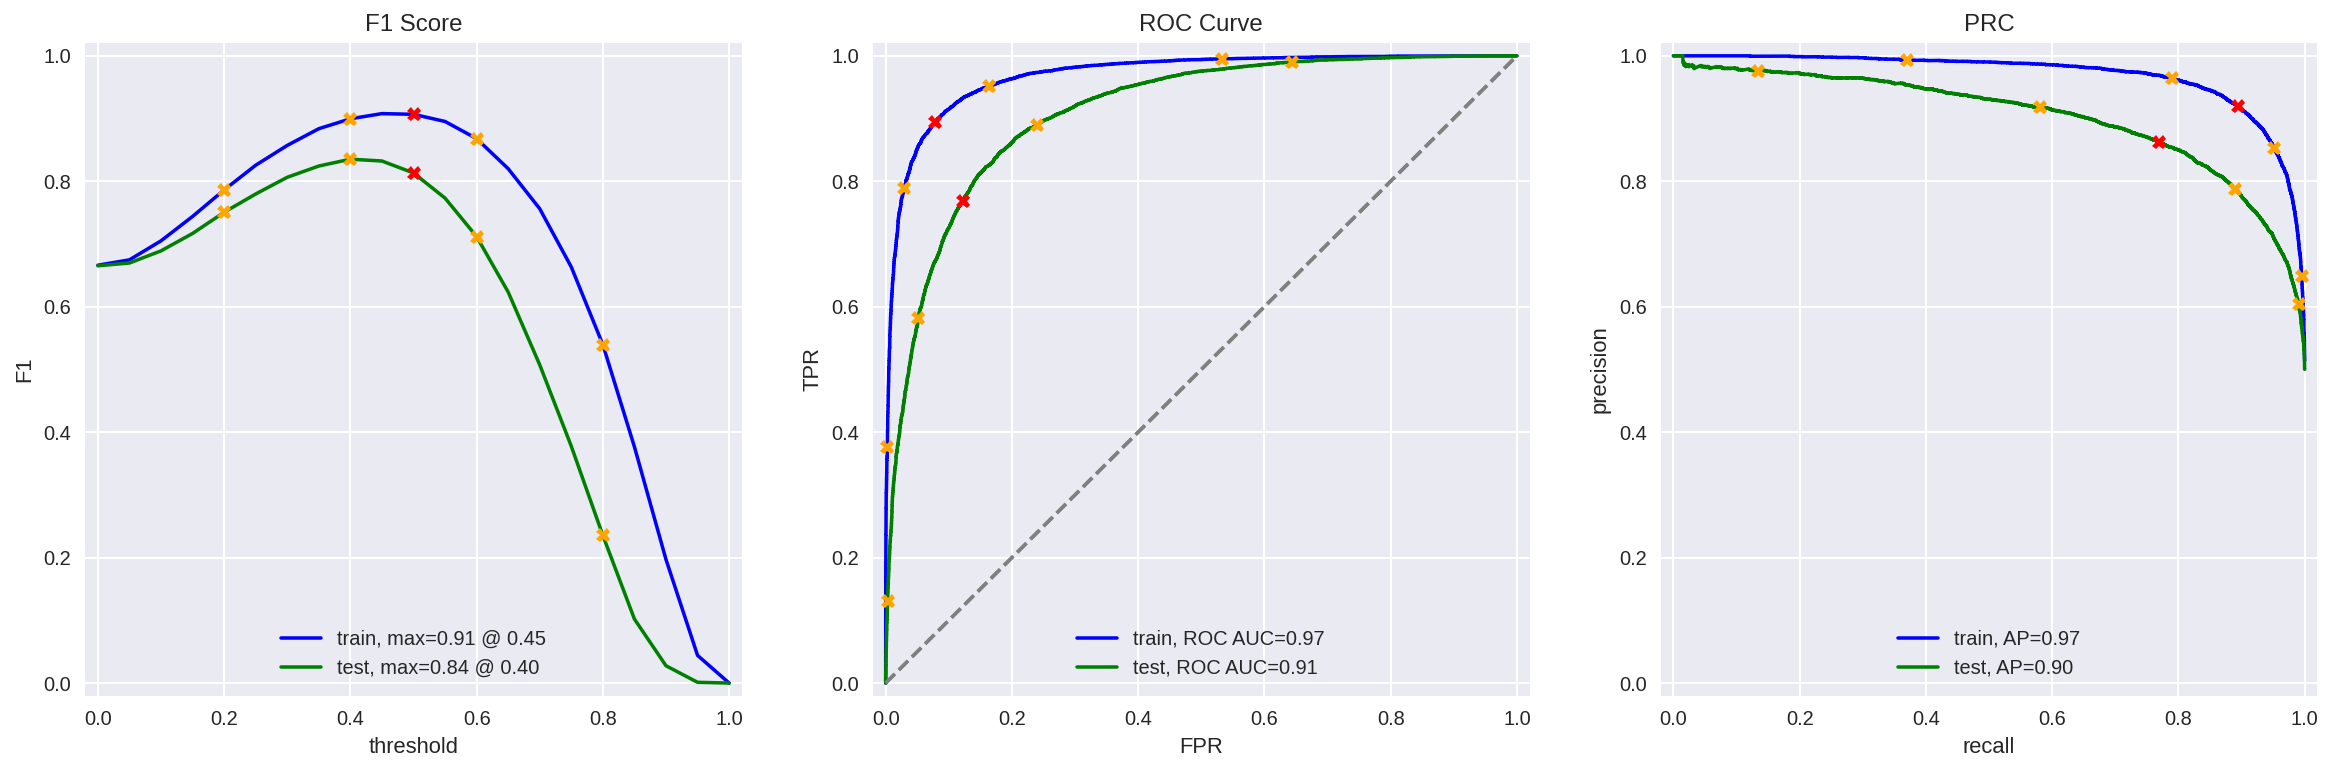

In [156]:
# Evaluating model
evaluate_model(nb_spacy, spacy_X_train, y_train, spacy_X_test, y_test)



#### LightGBM Classifier Model

In [157]:
%%time 

# LightGBM classifier model with Spacy
lgbm_spacy = LGBMClassifier(random_state=12345)
lgbm_spacy.fit(spacy_X_train, y_train)

CPU times: user 1min 4s, sys: 338 ms, total: 1min 4s
Wall time: 1min 4s


          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


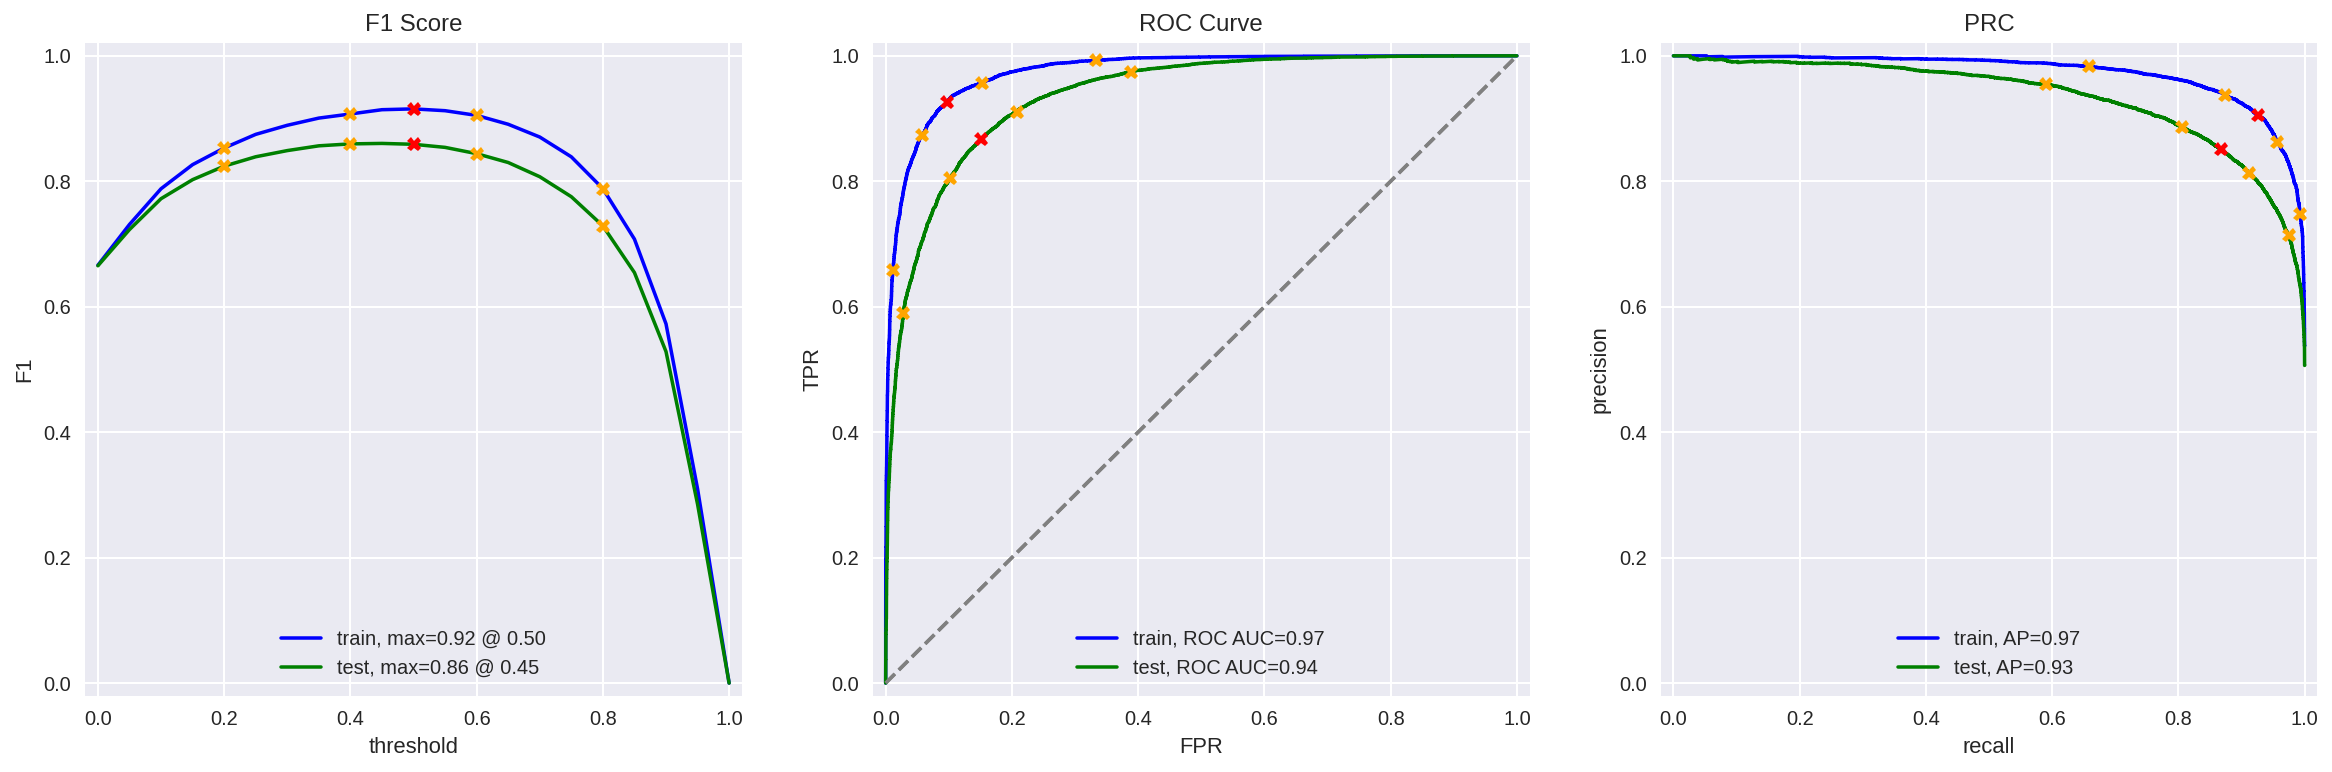

In [158]:
# Evaluating model
evaluate_model(lgbm_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### Conclusion

Using SpaCy to preprocess texts, we obtained a F1-score of 0.88 for the logistic regression model. The Naïve Bayes classification model obtained a F1-score of 0.81 which falls below the required F1 score of at least 0.85. The LightGBM classification model obtained a F1-score of 0.86.  The best model to use with spaCy was the logistic regression model. It was able to train the model the fastest (1.9 s) and achieve the highest F1 score. 

###  Model 3 - BERT

In [159]:
# Maximum sample size
max_sample_size = 200

In [160]:
# Preprocessing text with Bert's tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [161]:
# Function to preprocess text
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    max_sample_size = 200

    # text to padded ids of tokens along with their attention masks
    
    for text in texts.iloc[:max_sample_size]['review']:
      ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
      padded = np.array( ids + [0]*(max_length - len(ids)))
      attention_mask = np.where(padded != 0, 1, 0)
      ids_list.append(padded)
      attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [164]:
%%time

# Setting training features and target
X_bert_train = BERT_text_to_embeddings(df_reviews_train, force_device='cpu')
y_bert_train = df_reviews_train.iloc[:max_sample_size]['pos']

Using the cpu device.


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


CPU times: user 6min, sys: 10.1 s, total: 6min 10s
Wall time: 6min 12s


In [165]:
print(df_reviews_train['review_norm'].shape)
print(X_bert_train.shape)
print(y_bert_train.shape)

(23796,)
(200, 768)
(200,)


In [166]:
%%time 

# Setting test features and target
X_bert_test = BERT_text_to_embeddings(df_reviews_test, force_device='cpu')
y_bert_test = df_reviews_test.iloc[:max_sample_size]['pos']

Using the cpu device.


  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 5min 58s, sys: 7.36 s, total: 6min 5s
Wall time: 6min 4s


In [167]:
print(df_reviews_test['review_norm'].shape)
print(X_bert_test.shape)
print(y_bert_test.shape)

(23533,)
(200, 768)
(200,)


In [168]:
# Normalizing features
scaler = MinMaxScaler()
scaler.fit(X_bert_train)
X_bert_train = scaler.transform(X_bert_train)
X_bert_test = scaler.transform(X_bert_test)

#### Logistic Regression Model

In [169]:
%%time

# Logistic regression model with BERT
lr_bert = LogisticRegression(random_state=12345)
lr_bert.fit(X_bert_train, y_bert_train)

CPU times: user 58.3 ms, sys: 59.2 ms, total: 117 ms
Wall time: 146 ms


          train  test
Accuracy    1.0  0.82
F1          1.0  0.81
APS         1.0  0.94
ROC AUC     1.0  0.92


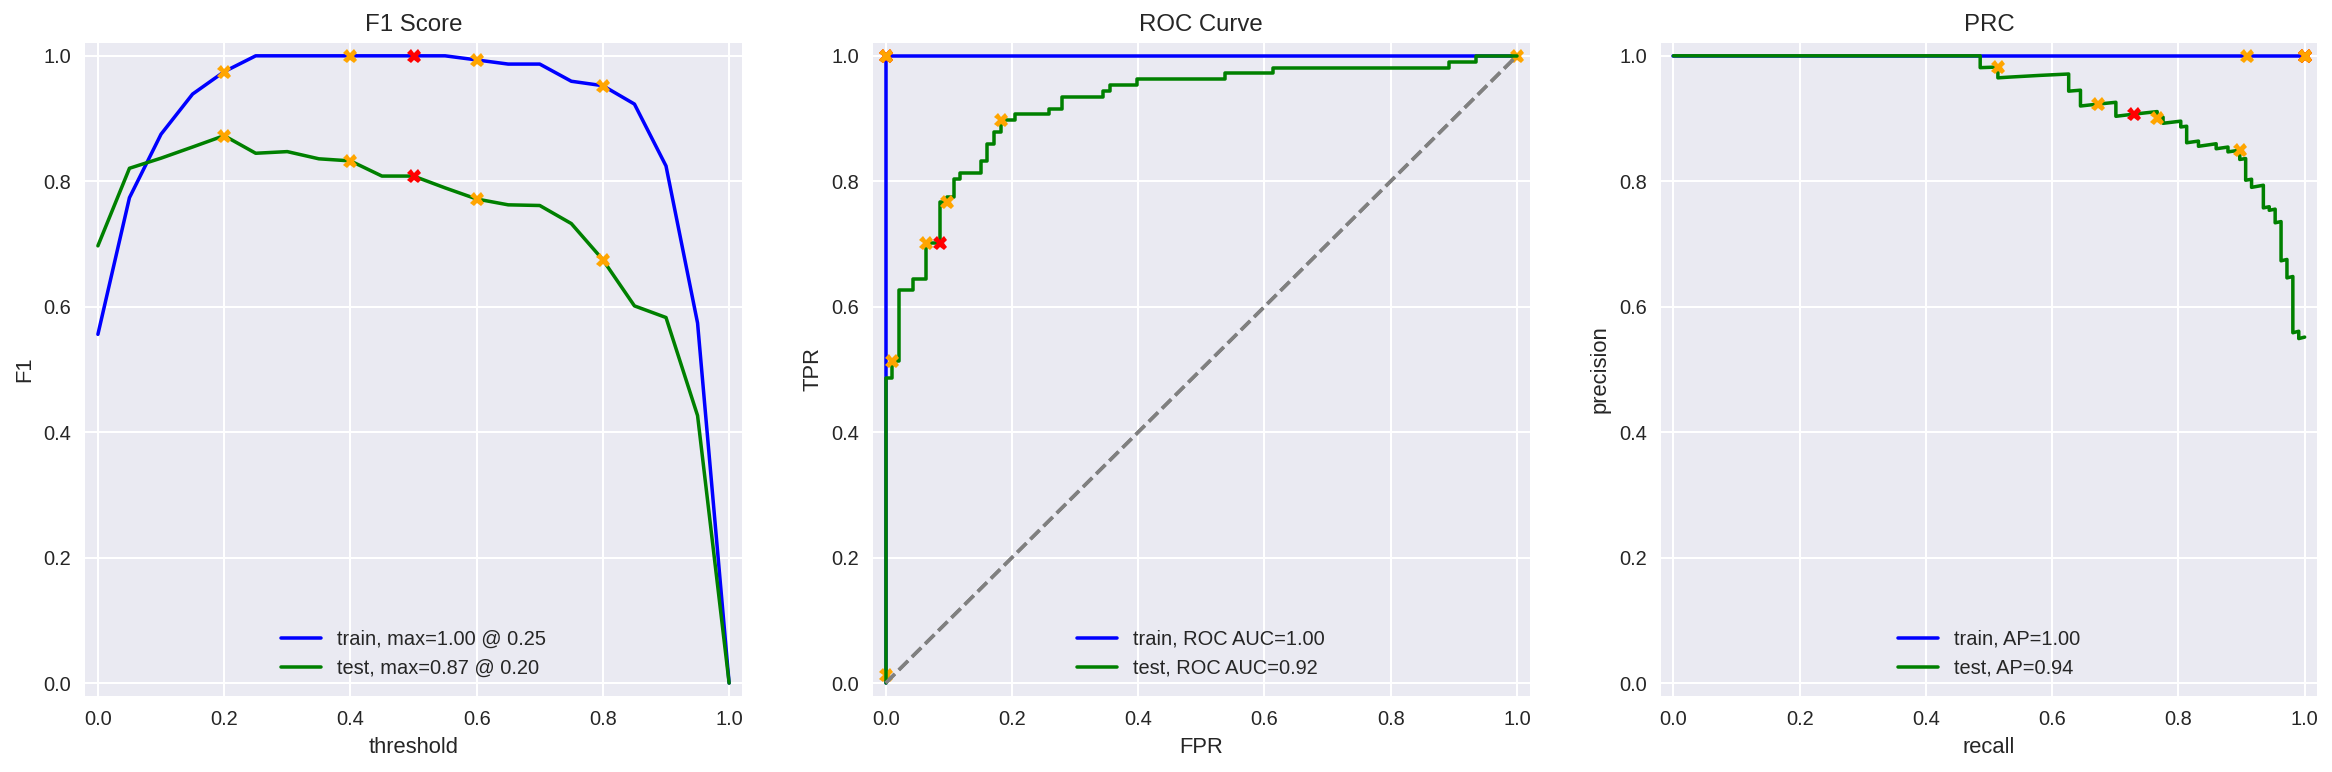

In [170]:
# Evaluating model
evaluate_model(lr_bert, X_bert_train, y_bert_train, X_bert_test, y_bert_test)

#### Naive Bayes Classifier Model

In [171]:
%%time

# Naive Bayes classifier model with BERT
nb_bert = MultinomialNB()
nb_bert.fit(X_bert_train, y_bert_train)

CPU times: user 9.88 ms, sys: 14 ms, total: 23.9 ms
Wall time: 19.6 ms


          train  test
Accuracy   0.84  0.71
F1         0.77  0.68
APS        0.88  0.85
ROC AUC    0.90  0.83


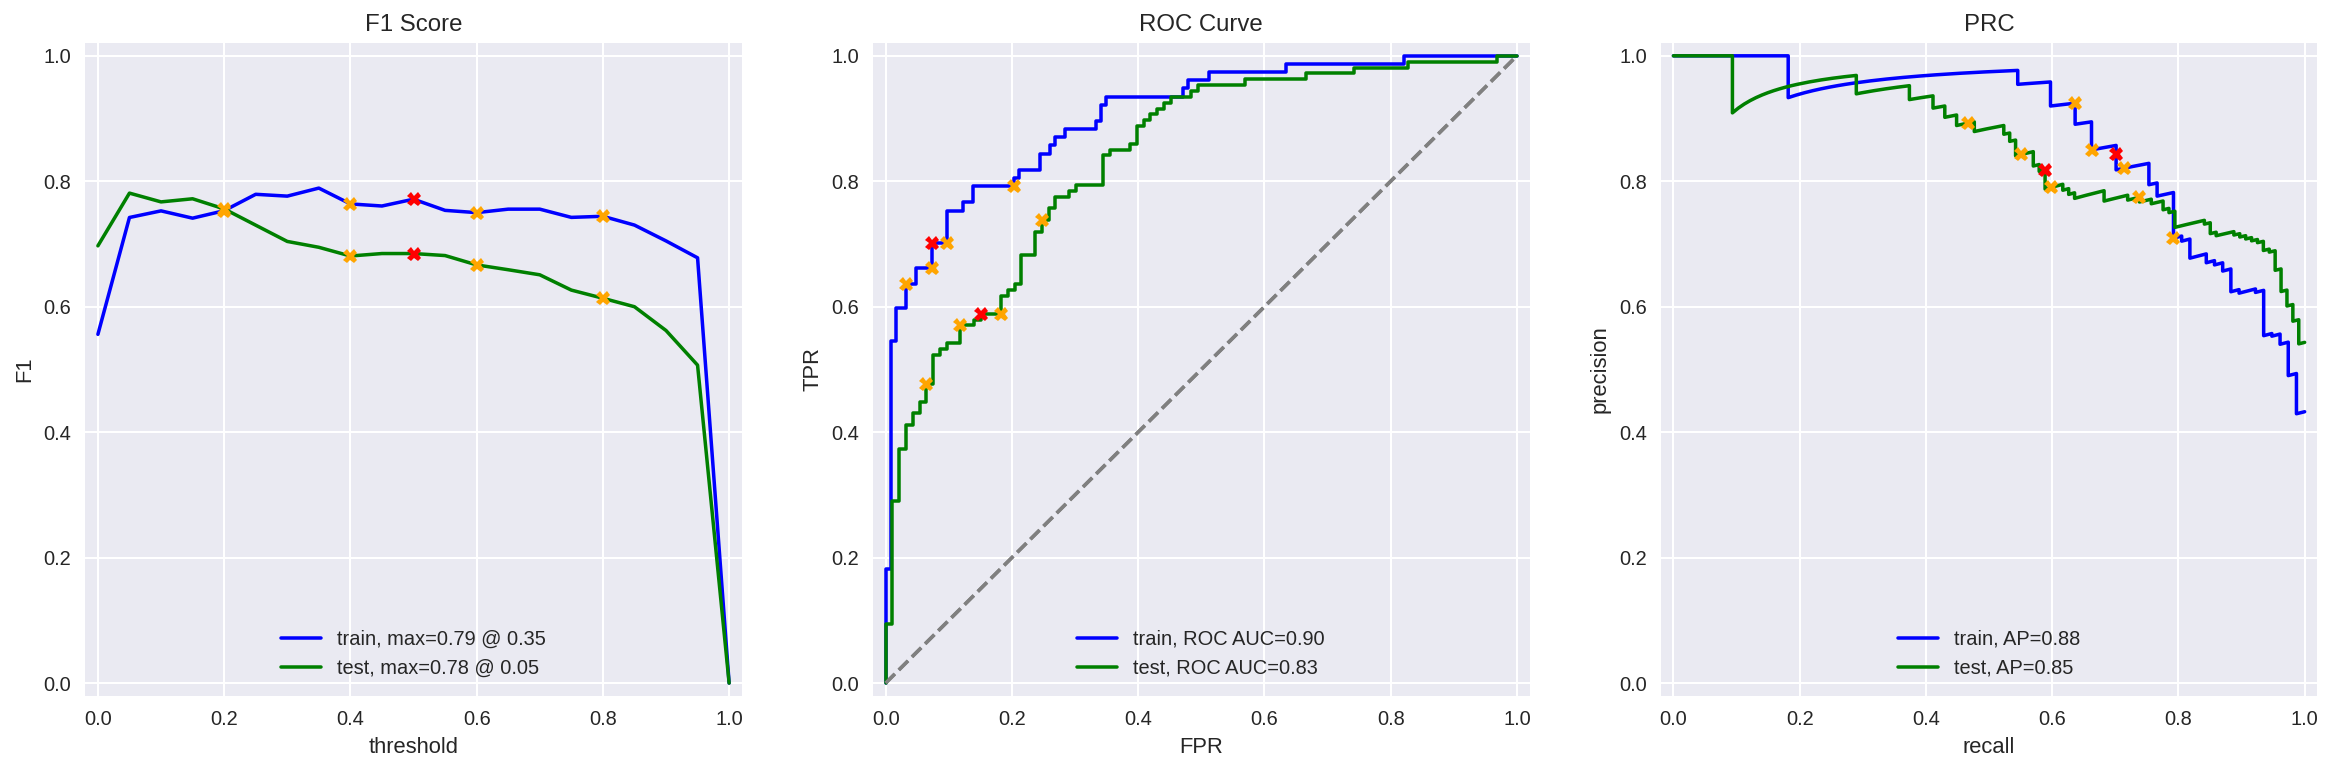

In [172]:
# Evaluating model
evaluate_model(nb_bert, X_bert_train, y_bert_train, X_bert_test, y_bert_test)

#### LightGBM Classfier Model

In [173]:
%%time 

# LightGBM classifier model wiht BERT
lgbm_bert = LGBMClassifier(random_state=12345)
lgbm_bert.fit(X_bert_train, y_bert_train)

CPU times: user 770 ms, sys: 29.9 ms, total: 800 ms
Wall time: 809 ms


          train  test
Accuracy    1.0  0.79
F1          1.0  0.78
APS         1.0  0.90
ROC AUC     1.0  0.90


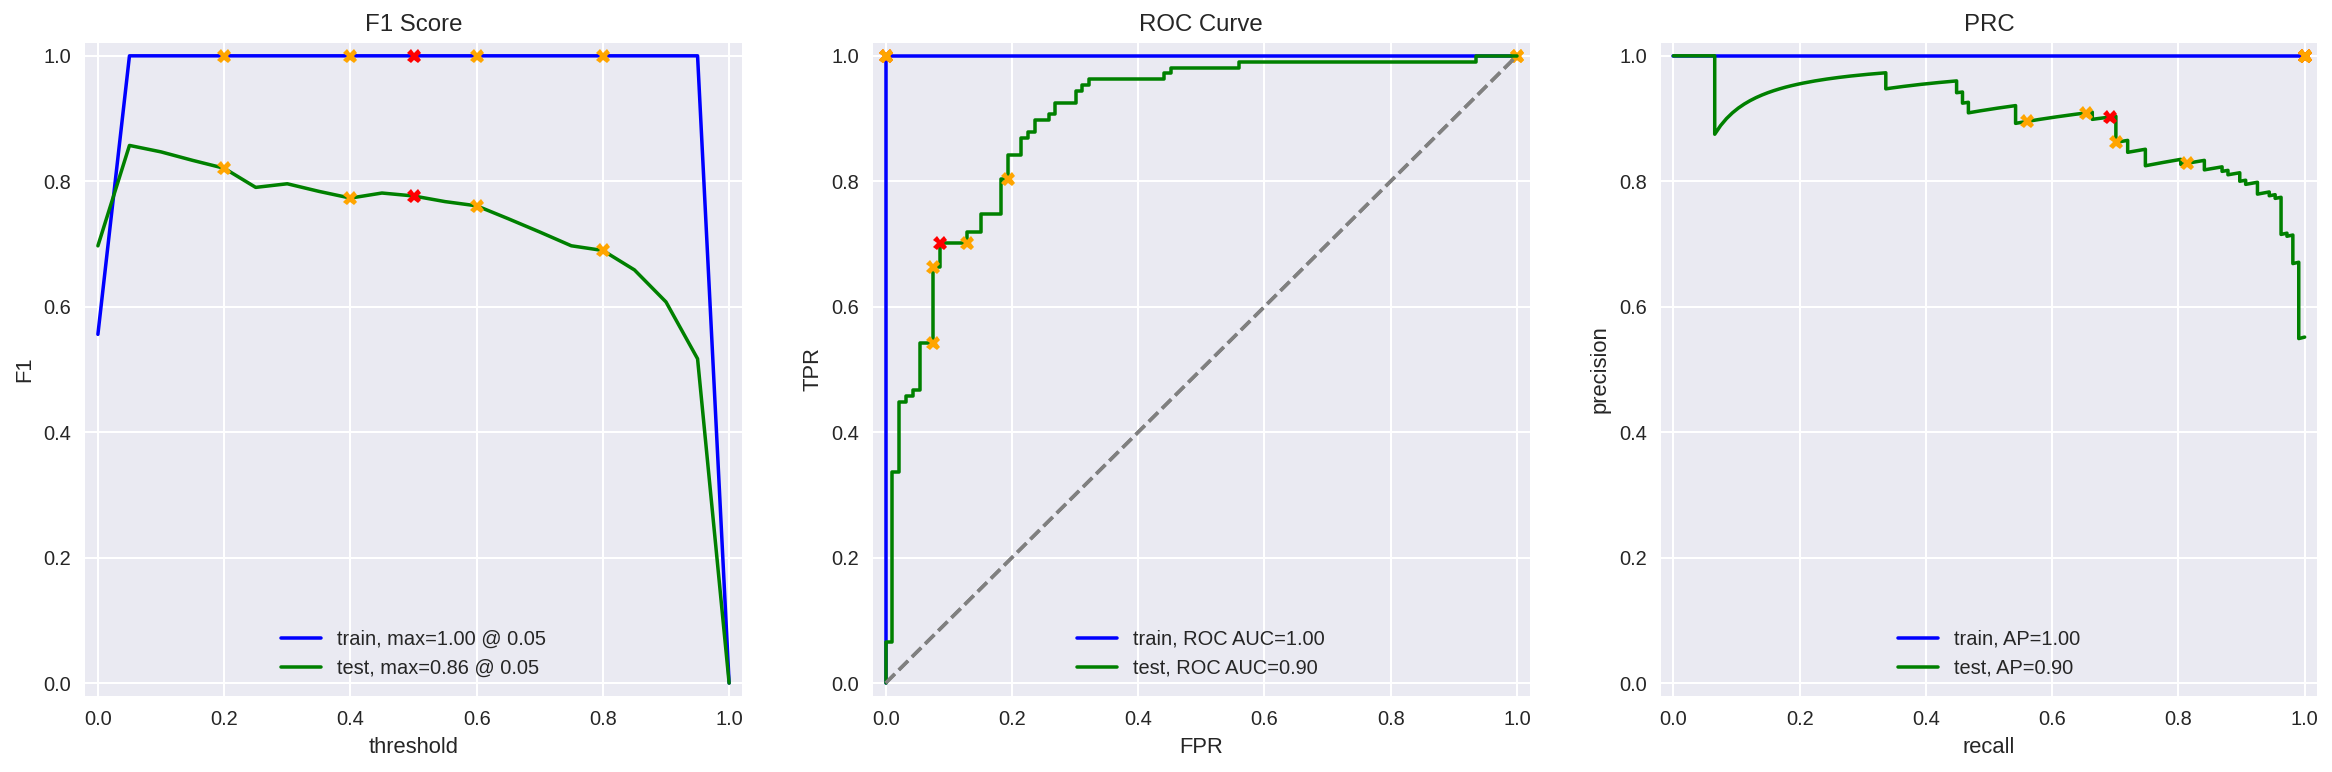

In [174]:
# Evaluating model
evaluate_model(lgbm_bert, X_bert_train, y_bert_train, X_bert_test, y_bert_test)

#### Conclusion

BERT was used only on a subset of the data. Using a maximum sample size of 200 for computing BERT embeddings, it took about 6 minutes to compute the train and test set. The logistic regression model obtained a F1 score of 0.81. The Naïve Bayes classifier model obtained a F1 score of 0.68. The LightGBM classifier model obtained a F1 score of 0.78. None of the models met the threshold F1 score of 0.85. The model with the closest F1 score to the threshold was the logistic regression model.   

## My Reviews

In [176]:
# Composing own reviews

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_text)

my_reviews

review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0      i did not simply like it not my kind of movie  
1  well i was bored and felt asleep in the middle...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn't expect the reboot to be so good write...  
5  the movie had its upsides and downsides but i ...  
6  what a rotten attempt at a comedy not a single...  
7  launching on netflix was a brave move i really...

### Logistic Regression Model

In [207]:
texts = my_reviews['review_norm']

lr_pred = lr_spacy.predict(count_tf_idf.transform(texts))

lr_pred_prob = lr_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]


print('Pos'+'  '+'Proba'+'  '+'Actual review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f' {lr_pred[i]}   {lr_pred_prob[i]:.2f}   {review}')

Pos  Proba  Actual review
 0   0.16   i did not simply like it not my kind of movie
 0   0.23   well i was bored and felt asleep in the middle of the movie
 0   0.47   i was really fascinated with the movie
 0   0.34   even the actors looked really old and disinterested and they got paid to be in the movie what a soul
 0   0.42   i didn't expect the reboot to be so good writers really cared about the source material
 0   0.41   the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
 0   0.05   what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
 1   0.91   launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Naive Bayes Classifier Model

In [205]:
texts = my_reviews['review_norm']

nb_pred = nb_spacy.predict(count_tf_idf.transform(texts))

nb_pred_prob = nb_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]


print('Pos:'+'  '+'Proba'+'   '+'Actual review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f' {nb_pred[i]}    {nb_pred_prob[i]:.2f}    {review}')

Pos:  Proba   Actual review
 0    0.37    i did not simply like it not my kind of movie
 0    0.22    well i was bored and felt asleep in the middle of the movie
 1    0.63    i was really fascinated with the movie
 1    0.50    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
 0    0.43    i didn't expect the reboot to be so good writers really cared about the source material
 0    0.36    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
 0    0.17    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
 1    0.65    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### LightGBM Classifier Model

In [209]:
texts = my_reviews['review_norm']

lgbm_pred = lgbm_spacy.predict(count_tf_idf.transform(texts))

lgbm_pred_prob = lgbm_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]

print('Pos'+'  '+'Proba'+'  '+'Actual review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f' {lgbm_pred[i]}   {lgbm_pred_prob[i]:.2f}   {review}')

Pos  Proba  Actual review
 1   0.54   i did not simply like it not my kind of movie
 0   0.48   well i was bored and felt asleep in the middle of the movie
 1   0.60   i was really fascinated with the movie
 0   0.49   even the actors looked really old and disinterested and they got paid to be in the movie what a soul
 1   0.71   i didn't expect the reboot to be so good writers really cared about the source material
 1   0.65   the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
 0   0.24   what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
 1   0.78   launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Conclusion 

We created four positive and four negative reviews and classified them with different models. The logistic model was only able to identify one positive review, while the rest were negative. The Naïve Bayes classifier model was able to find three positive reviews and five negative reviews. The LightGBM classifier model identified five positive reviews and three negative reviews. The LightGBM and Naïve Bayes classifier model were the best in identifying the difference in negative and positive reviews. 

## Findings


We plotted the distribution of movies and reviews over the years and found that the number of movies and reviews increased over the years until 2007, then there was a sharp decline in both movies released and movie reviews. Our pie chart of `pos` (our target) showed that there was roughly an even distribution of positive and negative ratings. About 49.9% of the ratings were positive and 50.1% of the ratings were negative. The plots for the ratings of the training set and test set showed that they both had similar distributions. A word cloud was also used to visualize the top 100 positive and negative words in the `review` column. 

We created a dummy classifier model to serve as our baseline model and obtained an accuracy rate of 50% and a F1 score of 0.5.

We used NLTK to preprocess texts and trained three different models: logistic regression model, Naïve Bayes classifier model, and the LightGBM classifier model.

* The logistic regression model obtained a F1 score of 0.88
* The Naïve Bayes classification model obtained a F1 score of 0.82
* The LightGBM model obtained a F1 score of 0.86

The Naïve Bayes classification model obtained a F1-score of 0.82 which falls below the required F1 score of at least 0.85. The LightGBM classification model obtained a F1-score of 0.86. The best model to use with NLTK was the logistic regression model. It was able to train the model fast and achieve the highest F1 score.

SpaCy was also used to preprocess texts. We trained three different models after preprocessing with spaCy.
* The logistic regression model obtained a F1 score of 0.88
* The Naïve Bayes classification model obtained a F1 score of 0.81
* The LightGBM model obtained a F1 score of 0.86

The F1 score of the Naïve Bayes model fell below the required threshold score of 0.85. The best model to use with spaCy was the logistic regression model. It was able to train the model the fastest (1.9 s) and also achieved the highest F1 score. 

BERT was used only a small subset of the data. We used a maximum sample size of 200 to compute BERT embeddings. It took about 6 minutes to compute the embeddings for the train and test sets. 
* The logistic regression model obtained a F1 score of 0.81
* The Naïve Bayes classification model obtained a F1 score of 0.68
* The LightGBM classification model obtained a F1 score of 0.78

None of the models met the threshold F1 score of 0.85. The model with the closest F1 score to the threshold was the logistic regression model. 

We also composed a few reviews and classified them with different models. Four positive and four negative reviews were created. Since models with spaCy preprocessing obtained the highest F1 scores, we classified our reviews using the models with trained using spaCy text preprocessing. 
* The logistic regression model identified 1 positive review and 7 negative reviews
* The Naïve Bayes classifier model identified 3 positive reviews and 5 negative reviews
* The LightGBM classifier model identified 5 positive reviews and 3 negative reviews

The LightGBM and Naïve Bayes classifier models were the best in identifying the differences in negative and positive reviews.